#Utility functions, parameters, and Google Drive

In [ ]:
#@title General parameters { run: "auto", display-mode: "form" }
from torchvision import transforms
import PIL.Image

_nb_epochs = 50 #@param {type:"integer"}
_log_interval = 1 #@param {type:"integer"}
_dataset = "CIFAR-10" #@param ["ImageNet-16", "CIFAR-10", "CIFAR-100", "CINIC-10"]

_interpolation_method = "nearest" #@param ["nearest", "bilinear", "cubic"]
if "nearest" == _interpolation_method:
    _interpolation_method = PIL.Image.NEAREST
elif "bilinear" == _interpolation_method:
    _interpolation_method = PIL.Image.BILINEAR
elif "cubic" == _interpolation_method:
    _interpolation_method = PIL.Image.CUBIC
    
_transformations = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [ ]:
#@title AlexNet parameters

_alex_enabled = True #@param {type:"boolean"}
if _alex_enabled:
    _alex_learning_rate = 0.01 #@param {type:"number"}
    _alex_momentum = 0.9 #@param {type:"number"}
    _alex_weight_decay=0.000 #@param {type:"number"}
    _alex_scheduler="Step" #@param ["Step", "Adaptive"]
    _alex_step_size=10 #@param {type:"number"}
    _alex_gamma = 0.1 #@param {type:"number"}
    _alex_pretrained = False #@param {type:"boolean"}

In [ ]:
#@title SqueezeNet parameters

_squeeze_learning_rate = 0.001 #@param {type:"number"}
_squeeze_momentum = 0.9 #@param {type:"number"}
_squeeze_weight_decay=0.0002 #@param {type:"number"}
_squeeze_scheduler="Step" #@param ["Step", "Adaptive"]
_squeeze_step_size=10 #@param {type:"number"}
_squeeze_gamma = 0.1 #@param {type:"number"}
_squeeze_pretrained = False #@param {type:"boolean"}

In [ ]:
#@title Google Drive {run: "auto"}
from google.colab import drive

drive.mount('/gdrive', force_remount=True)
data_folder = '/gdrive/My Drive/COMP551_Assignment3_data/'


Mounted at /gdrive


In [ ]:
#@title Utility functions

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
        
    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
                    
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

def try_makedirs(d):
    import os
    try:
        os.makedirs(d)
    except FileExistsError as e:
        pass

def load_image(filename):
    return \
        PIL.Image.open(filename)\
          .convert('RGB')

# def load_image(filename):
#     return \
#         PIL.Image.open(filename)\
#           .resize((64,64), _interpolation_method)\
#           .convert('RGB')

# def load_image(filename):
#     return np.array(
#         PIL.Image.open(filename)\
#           .resize((64,64), _interpolation_method)\
#           .convert('RGB'),
#         dtype=np.float32
#     )/255


def plot_results(
    results_1, model_1_name, model_1_color,
    results_2, model_2_name, model_2_color
):
    import matplotlib.pyplot as plt
    
    x = range(1, 1+results_1.shape[0])
    one_plt = plt.plot(x, results_1[:,1], model_1_color + '-', x, results_1[:,1], model_1_color + 'o')
    two_plt = plt.plot(x, results_2[:,1], model_2_color + '-', x, results_2[:,1], model_2_color + 'o')
    
    for i in range(1, _nb_epochs):
        if results_2[i,2] != results_2[i-1,2] \
          and not np.isnan(results_2[i,2]) \
          and not np.isnan(results_2[i-1, 2]):
            plt.plot([i-0.1, i-0.1], [0, 100], model_1_color + '--')
        if results_1[i,2] != results_1[i-1,2] \
          and not np.isnan(results_1[i,2]) \
          and not np.isnan(results_1[i-1, 2]):
            plt.plot([i+0.1, i+0.1], [0, 100], model_2_color + '--')

    plt.legend((one_plt[0], two_plt[0]), (model_1_name, model_2_name))
    plt.title('Model accuracy improvement over time')
    plt.xlabel('# of epochs')
    plt.xticks(np.linspace(1, results_1.shape[0], 11))
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    plt.yticks(np.linspace(0, 100, 11));
    plt.draw()
    
    
def plot_results_to_grid(
    grid, where,
    results_1, model_1_name, model_1_color,
    results_2, model_2_name, model_2_color
):
    import matplotlib.pyplot as plt
    
    with grid.output_to(where[0], where[1]):
        grid.clear_cell()
        plot_results(results_1, model_1_name, model_1_color, results_2, model_2_name, model_2_color)

        
def elapsed_time(model_name, i):
    import time
    
    if 0 == i:
        elapsed_time.start = time.time()
    else:
        print(
            "{{{}}} The last training epoch took {} seconds.\n\n".format(
                model_name, time.time() - elapsed_time.start
            )
        )
        

class CatchIO:
    def __init__(self):
        self._stdout = None
        self.buffer = None
    
    def __enter__(self):
        import sys
        import io
        
        self._stdout = sys.stdout
        sys.stdout = io.StringIO()
    
    def __exit__(self, type_, value, traceback):
        import sys
        
        self.buffer = sys.stdout.getvalue()
        sys.stdout = self._stdout
        if value is not None:
            raise value


#Models and datasets

In [ ]:
#@title AlexNet{display-mode: "form"}
from torchvision.models.alexnet import alexnet
import torch.nn as nn
import torch.nn.functional as F
 
class AlexNet(nn.Module):
  
    def __init__(self):
        super(AlexNet, self).__init__()
        self.alex = alexnet(pretrained=_alex_pretrained, num_classes=1000);
   
    def forward(self, x):
        return F.log_softmax(self.alex.forward(x), dim=1)

In [ ]:
#@title SqueezeNet {display-mode: "form"}
import torchvision.models.squeezenet
import torch.nn as nn
import torch.nn.functional as F

class SqueezeNet(nn.Module):
  
    def __init__(self):
        super(SqueezeNet, self).__init__()
        self.squeeze = torchvision.models.squeezenet.squeezenet1_0(pretrained=_squeeze_pretrained, num_classes=1000);
   
    def forward(self, x):
        return F.log_softmax(self.squeeze.forward(x), dim=1)

In [ ]:
#@title ImageNet-16 _(warning: very slow)_
from torchvision.datasets import DatasetFolder

from zipfile import ZipFile
import os
import pandas
import PIL.Image
import numpy as np

path_to_ImageNet16 = "COMP551_Assignment4/data/" #@param {type:"string"}

if "ImageNet-16" == _dataset:
    IMGSZ = (16,16,3)
    NUM_IMAGES = 1275273

    train_pickle_folder = 'data/16/train/pickle'
    train_image_folder = 'data/16/train/images'
    valid_image_folder = 'data/16/validation/images'
    test_pickle_folder = 'data/16/test/pickle'
    test_image_folder = 'data/16/test/images'

    force = False #@param {type:"boolean"}
    train_valid_split = 0.9 #@param {type:"slider", min:0, max:1, step:0.05}

    ct = np.zeros(1000)

    if not os.path.exists(train_image_folder) or force:
        # Create folders
        try_makedirs(train_pickle_folder)
        try_makedirs(train_image_folder)
        try_makedirs(valid_image_folder)
        try_makedirs(test_pickle_folder)
        try_makedirs(test_image_folder)
        for ix in range(1000):
            try_makedirs(os.path.join(train_image_folder, "class_{}".format(1+ix)))
            try_makedirs(os.path.join(valid_image_folder, "class_{}".format(1+ix)))
            try_makedirs(os.path.join(test_image_folder, "class_{}".format(1+ix)))
        # Extract training data zipfile
        z = ZipFile(
            os.path.join(
                '/gdrive/My Drive/', path_to_ImageNet16, 'Imagenet16_train.zip'
            )
        )
        z.extractall(train_pickle_folder)
        z.close()
        # Extract training images to folders
        for ix in log_progress(
            range(1, 11), every=1, name="Converting pickle files to images"
        ):
            # Read pickle
            tmp = pandas.read_pickle(
                os.path.join(train_pickle_folder, 'train_data_batch_{}'.format(ix))
            )
            # CIFAR format to array of images
            train_images = tmp['data'] \
              .reshape(-1, IMGSZ[2], IMGSZ[0], IMGSZ[1]) \
              .transpose([0, 2, 3, 1])
            # Save images to png (lossless format)
            for jx in range(len(train_images)):
                label = tmp['labels'][jx]
                # Split training set into training and validation sets
                if ct[label-1] > np.floor(train_valid_split * NUM_IMAGES / 1000):
                    # validation
                    out_folder = valid_image_folder
                else:
                    # training
                    out_folder = train_image_folder
                    ct[label-1] = 1 + ct[label-1]
                # Save
                PIL.Image.fromarray(train_images[jx]).save(
                    os.path.join(
                        out_folder,
                        'class_{}'.format(label),
                        '{}.png'.format(jx)
                    )
                )
            # Remove pickle file since we're done with it
            os.remove(
                os.path.join(train_pickle_folder, 'train_data_batch_{}'.format(ix))
            )

        # Extract test data zipfile
        z = ZipFile(
            os.path.join(
                '/gdrive/My Drive/', path_to_ImageNet16, 'Imagenet16_val.zip'
            )
        )
        z.extractall(test_pickle_folder)
        z.close()
        # Extract test images to folders
        #   Read pickle
        tmp = pandas.read_pickle(os.path.join(test_pickle_folder, 'val_data'))
        #   CIFAR format to array of images
        test_images = tmp['data'] \
          .reshape(-1, IMGSZ[2], IMGSZ[0], IMGSZ[1]) \
          .transpose([0, 2, 3, 1])
        #   Save images to png (lossless format)
        for jx in range(len(test_images)):
            # Save
            PIL.Image.fromarray(test_images[jx]).save(
                os.path.join(
                    test_image_folder,
                    'class_{}'.format(tmp['labels'][jx]),
                    '{}.png'.format(jx)
                )
            )
        #   Remove pickle file since we're done with it
        os.remove(
            os.path.join(test_pickle_folder, 'val_data')
        )

    trainset = DatasetFolder(
        train_image_folder, load_image, ['png'],
        transform=_transformations
    )
    validset = DatasetFolder(
        valid_image_folder, load_image, ['png'],
        transform=_transformations
    )
    testset = DatasetFolder(
        test_image_folder, load_image, ['png'],
        transform=_transformations
    )

else:
    print('Disabled')


Disabled


In [ ]:
#@title CIFAR-10
from torchvision.datasets import DatasetFolder
import tarfile
import os
import pandas
import PIL.Image
import numpy as np

path_to_CIFAR10 = "COMP551_Assignment4/data/" #@param {type:"string"}

if "CIFAR-10" == _dataset:
    IMGSZ = (32, 32, 3)
    NUM_IMAGES = 50000
    NUM_CLASSES = 10

    pickle_folder = 'data/CIFAR10/pickle'
    train_image_folder = 'data/CIFAR10/train/images'
    valid_image_folder = 'data/CIFAR10/validation/images'
    test_image_folder = 'data/CIFAR10/test/images'

    force = False #@param {type:"boolean"}
    train_valid_split = 0.9 #@param {type:"slider", min:0, max:1, step:0.05}

    ct = np.zeros(NUM_CLASSES)

    if not os.path.exists(train_image_folder) or force:
        # Create folders
        try_makedirs(pickle_folder)
        try_makedirs(train_image_folder)
        try_makedirs(valid_image_folder)
        try_makedirs(test_image_folder)
        for ix in range(NUM_CLASSES):
            try_makedirs(os.path.join(train_image_folder, "class_{}".format(ix)))
            try_makedirs(os.path.join(valid_image_folder, "class_{}".format(ix)))
            try_makedirs(os.path.join(test_image_folder, "class_{}".format(ix)))
        # Extract training data zipfile
        tar = tarfile.open(
            os.path.join(
                '/gdrive/My Drive/', path_to_CIFAR10, 'cifar-10-python.tar.gz'
            )
        )
        tar.extractall(pickle_folder)
        tar.close()
        # Extract training images to folders
        for ix in log_progress(
            range(1, 6), every=1, name="Converting pickle files to images"
        ):
            # Read pickle
            tmp = pandas.read_pickle(
                os.path.join(
                    pickle_folder, 'cifar-10-batches-py', 'data_batch_{}'.format(ix)
                )
            )
            # CIFAR format to array of images
            train_images = tmp['data'] \
              .reshape(-1, IMGSZ[2], IMGSZ[0], IMGSZ[1]) \
              .transpose([0, 2, 3, 1])
            # Save images to png (lossless format)
            for jx in range(len(train_images)):
                label = tmp['labels'][jx]
                # Split training set into training and validation sets
                if ct[label-1] >= np.floor(train_valid_split * NUM_IMAGES / NUM_CLASSES):
                    # validation
                    out_folder = valid_image_folder
                else:
                    # training
                    out_folder = train_image_folder
                    ct[label-1] = 1 + ct[label-1]
                # Save
                PIL.Image.fromarray(train_images[jx]).save(
                    os.path.join(
                        out_folder,
                        'class_{}'.format(label),
                        '{}.png'.format(jx)
                    )
                )
            # Remove pickle file since we're done with it
            os.remove(
                os.path.join(
                    pickle_folder,
                    'cifar-10-batches-py', 
                    'data_batch_{}'.format(ix)
                )
            )

        # Extract test images to folders
        #   Read pickle
        tmp = pandas.read_pickle(
            os.path.join(pickle_folder, 'cifar-10-batches-py', 'test_batch')
        )
        #   CIFAR format to array of images
        test_images = tmp['data']\
          .reshape(-1, IMGSZ[2], IMGSZ[0], IMGSZ[1]) \
          .transpose([0, 2, 3, 1])
        #   Save images to png (lossless format)
        for jx in range(len(test_images)):
            # Save
            PIL.Image.fromarray(test_images[jx]).save(
                os.path.join(
                    test_image_folder,
                    'class_{}'.format(tmp['labels'][jx]),
                    '{}.png'.format(jx)
                )
            )
        #   Remove pickle file since we're done with it
        os.remove(
            os.path.join(pickle_folder, 'cifar-10-batches-py', 'test_batch')
        )
    trainset = DatasetFolder(
        train_image_folder, load_image, ['png'],
        transform=_transformations
    )
    validset = DatasetFolder(
        valid_image_folder, load_image, ['png'],
        transform=_transformations
    )
    testset = DatasetFolder(
        test_image_folder, load_image, ['png'],
        transform=_transformations
    )

else:
    print('Disabled')

In [ ]:
#@title CIFAR-100
from torchvision.datasets import DatasetFolder
import tarfile
import os
import pandas
import PIL.Image
import numpy as np

path_to_CIFAR100 = "COMP551_Assignment4/data/" #@param {type:"string"}

if "CIFAR-100" == _dataset:
    print('Loading CIFAR-100... ', end='')
    
    IMGSZ = (32, 32, 3)
    NUM_IMAGES = 50000
    NUM_CLASSES = 100

    pickle_folder = 'data/CIFAR100/pickle'
    train_image_folder = 'data/CIFAR100/train/images'
    valid_image_folder = 'data/CIFAR100/validation/images'
    test_image_folder = 'data/CIFAR100/test/images'

    label_type = "fine (100)" #@param ["fine (100)", "coarse (20)"]
    if label_type == "fine (100)":
        label_type = "fine_labels"
    elif label_type == "coarse (20)":
        label_type = "coarse_labels"
    
    force = False #@param {type:"boolean"}
    train_valid_split = 0.9 #@param {type:"slider", min:0, max:1, step:0.05}

    ct = np.zeros(NUM_CLASSES)

    if not os.path.exists(train_image_folder) or force:
        # Create folders
        try_makedirs(pickle_folder)
        try_makedirs(train_image_folder)
        try_makedirs(valid_image_folder)
        try_makedirs(test_image_folder)
        for ix in range(NUM_CLASSES):
            try_makedirs(os.path.join(train_image_folder, "class_{}".format(ix)))
            try_makedirs(os.path.join(valid_image_folder, "class_{}".format(ix)))
            try_makedirs(os.path.join(test_image_folder, "class_{}".format(ix)))
        # Extract training data zipfile
        tar = tarfile.open(
            os.path.join(
                '/gdrive/My Drive/', path_to_CIFAR100, 'cifar-100-python.tar.gz'
            )
        )
        tar.extractall(pickle_folder)
        tar.close()
        # Extract training images to folders
        # Read pickle
        tmp = pandas.read_pickle(
            os.path.join(pickle_folder, 'cifar-100-python', 'train')
        )
        tmp.keys()
        # CIFAR format to array of images
        train_images = tmp['data'] \
          .reshape(-1, IMGSZ[2], IMGSZ[0], IMGSZ[1]) \
          .transpose([0, 2, 3, 1])
        # Save images to png (lossless format)
        for jx in range(len(train_images)):
            label = tmp[label_type][jx]
            # Split training set into training and validation sets
            if ct[label-1] > np.floor(train_valid_split * NUM_IMAGES / NUM_CLASSES):
                # validation
                out_folder = valid_image_folder
            else:
                # training
                out_folder = train_image_folder
                ct[label-1] = 1 + ct[label-1]
            # Save
            PIL.Image.fromarray(train_images[jx]).save(
                os.path.join(
                    out_folder,
                    'class_{}'.format(label),
                    '{}.png'.format(jx)
                )
            )
        # Remove pickle file since we're done with it
        os.remove(os.path.join(pickle_folder, 'cifar-100-python', 'train'))

        # Extract test images to folders
        #   Read pickle
        tmp = pandas.read_pickle(
            os.path.join(pickle_folder, 'cifar-100-python', 'test')
        )
        #   CIFAR format to array of images
        test_images = tmp['data']\
          .reshape(-1, IMGSZ[2], IMGSZ[0], IMGSZ[1]) \
          .transpose([0, 2, 3, 1])
        #   Save images to png (lossless format)
        for jx in range(len(test_images)):
            # Save
            PIL.Image.fromarray(test_images[jx]).save(
                os.path.join(
                    test_image_folder,
                    'class_{}'.format(tmp[label_type][jx]),
                    '{}.png'.format(jx)
                )
            )
        #   Remove pickle file since we're done with it
        os.remove(
            os.path.join(pickle_folder, 'cifar-100-python', 'test')
        )
    
    trainset = DatasetFolder(
        train_image_folder, load_image, ['png'],
        transform=_transformations
    )
    validset = DatasetFolder(
        valid_image_folder, load_image, ['png'],
        transform=_transformations
    )
    testset = DatasetFolder(
        test_image_folder, load_image, ['png'],
        transform=_transformations
    )
    
    print('Done.')
    
else:
    print('Disabled')

Disabled


In [ ]:
#@title CINIC-10
from torchvision.datasets import ImageFolder
import tarfile
import os

path_to_CINIC = "NordVPN216856 " #@param {type:"string"}
force = False #@param {type:"boolean"}
image_folder = 'data/CINIC-10'

if "CINIC-10" == _dataset:
    print('Loading CIFAR-100... ', end='')

    if not os.path.exists(image_folder) or force:
        tar = tarfile.open(os.path.join('/gdrive/My Drive/', path_to_CINIC))
        try_makedirs(image_folder)
        tar.extractall(image_folder)
        tar.close()

    trainset = ImageFolder(
        os.path.join(image_folder, 'train'),
        loader=load_image,
        transform=_transformations
    )
    validset = ImageFolder(
        os.path.join(image_folder, 'valid'),
        loader=load_image,
        transform=_transformations
    )
    testset = ImageFolder(
        os.path.join(image_folder, 'test'),
        loader=load_image,
        transform=_transformations
    )
    
    print('done')

else:
    print('Disabled')

Disabled


In [ ]:
#@title Dataloader and model initialization
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch

import PIL.Image


def train(model, model_name, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % _log_interval == 0:
            print('{{{}}} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    model_name, epoch, batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()
                )
            )


def validate(model, model_name, device, validation_loader):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            validation_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(validation_loader.dataset)

    print(
        '\n{{{}}} Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
        .format(
            model_name, validation_loss, correct,
            len(validation_loader.dataset),
            100. * correct / len(validation_loader.dataset)
        )
    )

    return validation_loss, 100. * correct / len(validation_loader.dataset)


def test(model, model_name, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        '\n{{{}}} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
        .format(
            model_name, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)
        )
    )

    return test_loss, 100. * correct / len(test_loader.dataset)


#torch.manual_seed(1)

# Initialize training, validation, and test loaders
train_loader = DataLoader(trainset, batch_size=512, shuffle=True)
valid_loader = DataLoader(validset, batch_size=512, shuffle=True)
test_loader = DataLoader(testset, batch_size=512, shuffle=True)

# Initialize AlexNet
if _alex_enabled:
    alex = AlexNet().to("cuda")
    alex_opt = optim.SGD(
        alex.parameters(), lr=_alex_learning_rate, momentum=_alex_momentum,
        weight_decay=_alex_weight_decay
    )
    if "Step" == _alex_scheduler:
        alex_sch = optim.lr_scheduler.StepLR(alex_opt, _alex_step_size, _alex_gamma)
    elif "Adaptive" == _alex_scheduler:
        alex_sch = optim.lr_scheduler.ReduceLROnPlateau(alex_opt, factor=0.5, patience=2, verbose=True)
    else:
        assert False, "Scheduler type not recognized."

# Initialize SqueezeNet
squeeze = SqueezeNet().to("cuda")
squeeze_opt = optim.SGD(
    squeeze.parameters(), lr=_squeeze_learning_rate, momentum=_squeeze_momentum,
    weight_decay=_squeeze_weight_decay
)
if "Step" == _squeeze_scheduler:
    squeeze_sch = optim.lr_scheduler.StepLR(squeeze_opt, _squeeze_step_size, _squeeze_gamma)
elif "Adaptive" == _squeeze_scheduler:
    squeeze_sch = optim.lr_scheduler.ReduceLROnPlateau(alex_opt, factor=0.5, patience=2, verbose=True)
else:
    assert False, "Scheduler type not recognized."

# Done!
print('Dataloaders and models initialized.')

Dataloaders and models initialized.


37814 5000 0.883215770542346 10000


Text(0.5, 1.0, 'test set')

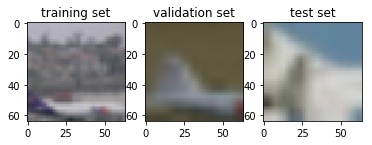

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print(
    len(trainset),
    len(validset),
    len(trainset) / (len(trainset) + len(validset)),
    len(testset)
)

plt.subplot(1, 3, 1)
plt.imshow(trainset[0][0].numpy().transpose([1, 2, 0]))
plt.title('training set')

plt.subplot(1, 3, 2)
plt.imshow(validset[0][0].numpy().transpose([1, 2, 0]))
plt.title('validation set')

plt.subplot(1, 3, 3)
plt.imshow(testset[0][0].numpy().transpose([1, 2, 0]));
plt.title('test set')

#Training and results

""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 1 [0/37814 (0%)]	Loss: 6.904803
{AlexNet} Train Epoch: 1 [512/37814 (1%)]	Loss: 6.902843
{AlexNet} Train Epoch: 1 [1024/37814 (3%)]	Loss: 6.899438
{AlexNet} Train Epoch: 1 [1536/37814 (4%)]	Loss: 6.897533
{AlexNet} Train Epoch: 1 [2048/37814 (5%)]	Loss: 6.891885
{AlexNet} Train Epoch: 1 [2560/37814 (7%)]	Loss: 6.885558
{AlexNet} Train Epoch: 1 [3072/37814 (8%)]	Loss: 6.878338
{AlexNet} Train Epoch: 1 [3584/37814 (9%)]	Loss: 6.869989
{AlexNet} Train Epoch: 1 [4096/37814 (11%)]	Loss: 6.862409
{AlexNet} Train Epoch: 1 [4608/37814 (12%)]	Loss: 6.852913
{AlexNet} Train Epoch: 1 [5120/37814 (14%)]	Loss: 6.843389
{AlexNet} Train Epoch: 1 [5632/37814 (15%)]	Loss: 6.833260
{AlexNet} Train Epoch: 1 [6144/37814 (16%)]	Loss: 6.823516
{AlexNet} Train Epoch: 1 [6656/37814 (18%)]	Loss: 6.811656
{AlexNet} Train Epoch: 1 [7168/37814 (19%)]	Loss: 6.799840
{AlexNet} Train Epoch: 1 [7680/37814 (20%)]	Loss: 6.786971
{AlexNet} Train Epoch: 1 [8192/37814 (22%)]	Loss: 6.774587
{AlexNet}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 2 [0/37814 (0%)]	Loss: 4.883925
{AlexNet} Train Epoch: 2 [512/37814 (1%)]	Loss: 4.936111
{AlexNet} Train Epoch: 2 [1024/37814 (3%)]	Loss: 5.025792
{AlexNet} Train Epoch: 2 [1536/37814 (4%)]	Loss: 4.836839
{AlexNet} Train Epoch: 2 [2048/37814 (5%)]	Loss: 4.968725
{AlexNet} Train Epoch: 2 [2560/37814 (7%)]	Loss: 4.748898
{AlexNet} Train Epoch: 2 [3072/37814 (8%)]	Loss: 4.414847
{AlexNet} Train Epoch: 2 [3584/37814 (9%)]	Loss: 4.481450
{AlexNet} Train Epoch: 2 [4096/37814 (11%)]	Loss: 4.318094
{AlexNet} Train Epoch: 2 [4608/37814 (12%)]	Loss: 4.195436
{AlexNet} Train Epoch: 2 [5120/37814 (14%)]	Loss: 4.184640
{AlexNet} Train Epoch: 2 [5632/37814 (15%)]	Loss: 4.337021
{AlexNet} Train Epoch: 2 [6144/37814 (16%)]	Loss: 3.949127
{AlexNet} Train Epoch: 2 [6656/37814 (18%)]	Loss: 3.797021
{AlexNet} Train Epoch: 2 [7168/37814 (19%)]	Loss: 3.739149
{AlexNet} Train Epoch: 2 [7680/37814 (20%)]	Loss: 3.745583
{AlexNet} Train Epoch: 2 [8192/37814 (22%)]	Loss: 3.494956
{AlexNet}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 3 [0/37814 (0%)]	Loss: 2.338313
{AlexNet} Train Epoch: 3 [512/37814 (1%)]	Loss: 2.313453
{AlexNet} Train Epoch: 3 [1024/37814 (3%)]	Loss: 2.315055
{AlexNet} Train Epoch: 3 [1536/37814 (4%)]	Loss: 2.316378
{AlexNet} Train Epoch: 3 [2048/37814 (5%)]	Loss: 2.308141
{AlexNet} Train Epoch: 3 [2560/37814 (7%)]	Loss: 2.316074
{AlexNet} Train Epoch: 3 [3072/37814 (8%)]	Loss: 2.307977
{AlexNet} Train Epoch: 3 [3584/37814 (9%)]	Loss: 2.309323
{AlexNet} Train Epoch: 3 [4096/37814 (11%)]	Loss: 2.313622
{AlexNet} Train Epoch: 3 [4608/37814 (12%)]	Loss: 2.310448
{AlexNet} Train Epoch: 3 [5120/37814 (14%)]	Loss: 2.311171
{AlexNet} Train Epoch: 3 [5632/37814 (15%)]	Loss: 2.314178
{AlexNet} Train Epoch: 3 [6144/37814 (16%)]	Loss: 2.303072
{AlexNet} Train Epoch: 3 [6656/37814 (18%)]	Loss: 2.306572
{AlexNet} Train Epoch: 3 [7168/37814 (19%)]	Loss: 2.310498
{AlexNet} Train Epoch: 3 [7680/37814 (20%)]	Loss: 2.305656
{AlexNet} Train Epoch: 3 [8192/37814 (22%)]	Loss: 2.314140
{AlexNet}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 4 [0/37814 (0%)]	Loss: 2.315112
{AlexNet} Train Epoch: 4 [512/37814 (1%)]	Loss: 2.305570
{AlexNet} Train Epoch: 4 [1024/37814 (3%)]	Loss: 2.307846
{AlexNet} Train Epoch: 4 [1536/37814 (4%)]	Loss: 2.307440
{AlexNet} Train Epoch: 4 [2048/37814 (5%)]	Loss: 2.314058
{AlexNet} Train Epoch: 4 [2560/37814 (7%)]	Loss: 2.319713
{AlexNet} Train Epoch: 4 [3072/37814 (8%)]	Loss: 2.306538
{AlexNet} Train Epoch: 4 [3584/37814 (9%)]	Loss: 2.309806
{AlexNet} Train Epoch: 4 [4096/37814 (11%)]	Loss: 2.312600
{AlexNet} Train Epoch: 4 [4608/37814 (12%)]	Loss: 2.317972
{AlexNet} Train Epoch: 4 [5120/37814 (14%)]	Loss: 2.309297
{AlexNet} Train Epoch: 4 [5632/37814 (15%)]	Loss: 2.304579
{AlexNet} Train Epoch: 4 [6144/37814 (16%)]	Loss: 2.309165
{AlexNet} Train Epoch: 4 [6656/37814 (18%)]	Loss: 2.305843
{AlexNet} Train Epoch: 4 [7168/37814 (19%)]	Loss: 2.302214
{AlexNet} Train Epoch: 4 [7680/37814 (20%)]	Loss: 2.338832
{AlexNet} Train Epoch: 4 [8192/37814 (22%)]	Loss: 2.311376
{AlexNet}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 5 [0/37814 (0%)]	Loss: 2.304966
{AlexNet} Train Epoch: 5 [512/37814 (1%)]	Loss: 2.315364
{AlexNet} Train Epoch: 5 [1024/37814 (3%)]	Loss: 2.304969
{AlexNet} Train Epoch: 5 [1536/37814 (4%)]	Loss: 2.309764
{AlexNet} Train Epoch: 5 [2048/37814 (5%)]	Loss: 2.312544
{AlexNet} Train Epoch: 5 [2560/37814 (7%)]	Loss: 2.311986
{AlexNet} Train Epoch: 5 [3072/37814 (8%)]	Loss: 2.306366
{AlexNet} Train Epoch: 5 [3584/37814 (9%)]	Loss: 2.308116
{AlexNet} Train Epoch: 5 [4096/37814 (11%)]	Loss: 2.318679
{AlexNet} Train Epoch: 5 [4608/37814 (12%)]	Loss: 2.306944
{AlexNet} Train Epoch: 5 [5120/37814 (14%)]	Loss: 2.317146
{AlexNet} Train Epoch: 5 [5632/37814 (15%)]	Loss: 2.305427
{AlexNet} Train Epoch: 5 [6144/37814 (16%)]	Loss: 2.303440
{AlexNet} Train Epoch: 5 [6656/37814 (18%)]	Loss: 2.315146
{AlexNet} Train Epoch: 5 [7168/37814 (19%)]	Loss: 2.318695
{AlexNet} Train Epoch: 5 [7680/37814 (20%)]	Loss: 2.320071
{AlexNet} Train Epoch: 5 [8192/37814 (22%)]	Loss: 2.313326
{AlexNet}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 6 [0/37814 (0%)]	Loss: 2.312593
{AlexNet} Train Epoch: 6 [512/37814 (1%)]	Loss: 2.307788
{AlexNet} Train Epoch: 6 [1024/37814 (3%)]	Loss: 2.319441
{AlexNet} Train Epoch: 6 [1536/37814 (4%)]	Loss: 2.318066
{AlexNet} Train Epoch: 6 [2048/37814 (5%)]	Loss: 2.306141
{AlexNet} Train Epoch: 6 [2560/37814 (7%)]	Loss: 2.304464
{AlexNet} Train Epoch: 6 [3072/37814 (8%)]	Loss: 2.298278
{AlexNet} Train Epoch: 6 [3584/37814 (9%)]	Loss: 2.315637
{AlexNet} Train Epoch: 6 [4096/37814 (11%)]	Loss: 2.314763
{AlexNet} Train Epoch: 6 [4608/37814 (12%)]	Loss: 2.308955
{AlexNet} Train Epoch: 6 [5120/37814 (14%)]	Loss: 2.310207
{AlexNet} Train Epoch: 6 [5632/37814 (15%)]	Loss: 2.303299
{AlexNet} Train Epoch: 6 [6144/37814 (16%)]	Loss: 2.310916
{AlexNet} Train Epoch: 6 [6656/37814 (18%)]	Loss: 2.302151
{AlexNet} Train Epoch: 6 [7168/37814 (19%)]	Loss: 2.307293
{AlexNet} Train Epoch: 6 [7680/37814 (20%)]	Loss: 2.309842
{AlexNet} Train Epoch: 6 [8192/37814 (22%)]	Loss: 2.305710
{AlexNet}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 7 [0/37814 (0%)]	Loss: 2.314878
{AlexNet} Train Epoch: 7 [512/37814 (1%)]	Loss: 2.313296
{AlexNet} Train Epoch: 7 [1024/37814 (3%)]	Loss: 2.300719
{AlexNet} Train Epoch: 7 [1536/37814 (4%)]	Loss: 2.301732
{AlexNet} Train Epoch: 7 [2048/37814 (5%)]	Loss: 2.303249
{AlexNet} Train Epoch: 7 [2560/37814 (7%)]	Loss: 2.299030
{AlexNet} Train Epoch: 7 [3072/37814 (8%)]	Loss: 2.293176
{AlexNet} Train Epoch: 7 [3584/37814 (9%)]	Loss: 2.300846
{AlexNet} Train Epoch: 7 [4096/37814 (11%)]	Loss: 2.301778
{AlexNet} Train Epoch: 7 [4608/37814 (12%)]	Loss: 2.312639
{AlexNet} Train Epoch: 7 [5120/37814 (14%)]	Loss: 2.311629
{AlexNet} Train Epoch: 7 [5632/37814 (15%)]	Loss: 2.299115
{AlexNet} Train Epoch: 7 [6144/37814 (16%)]	Loss: 2.308362
{AlexNet} Train Epoch: 7 [6656/37814 (18%)]	Loss: 2.287846
{AlexNet} Train Epoch: 7 [7168/37814 (19%)]	Loss: 2.296747
{AlexNet} Train Epoch: 7 [7680/37814 (20%)]	Loss: 2.298727
{AlexNet} Train Epoch: 7 [8192/37814 (22%)]	Loss: 2.303924
{AlexNet}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 8 [0/37814 (0%)]	Loss: 2.277581
{AlexNet} Train Epoch: 8 [512/37814 (1%)]	Loss: 2.260645
{AlexNet} Train Epoch: 8 [1024/37814 (3%)]	Loss: 2.272607
{AlexNet} Train Epoch: 8 [1536/37814 (4%)]	Loss: 2.261826
{AlexNet} Train Epoch: 8 [2048/37814 (5%)]	Loss: 2.254200
{AlexNet} Train Epoch: 8 [2560/37814 (7%)]	Loss: 2.262619
{AlexNet} Train Epoch: 8 [3072/37814 (8%)]	Loss: 2.257670
{AlexNet} Train Epoch: 8 [3584/37814 (9%)]	Loss: 2.257531
{AlexNet} Train Epoch: 8 [4096/37814 (11%)]	Loss: 2.273818
{AlexNet} Train Epoch: 8 [4608/37814 (12%)]	Loss: 2.261345
{AlexNet} Train Epoch: 8 [5120/37814 (14%)]	Loss: 2.265386
{AlexNet} Train Epoch: 8 [5632/37814 (15%)]	Loss: 2.262366
{AlexNet} Train Epoch: 8 [6144/37814 (16%)]	Loss: 2.244102
{AlexNet} Train Epoch: 8 [6656/37814 (18%)]	Loss: 2.257318
{AlexNet} Train Epoch: 8 [7168/37814 (19%)]	Loss: 2.267620
{AlexNet} Train Epoch: 8 [7680/37814 (20%)]	Loss: 2.257941
{AlexNet} Train Epoch: 8 [8192/37814 (22%)]	Loss: 2.258812
{AlexNet}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 9 [0/37814 (0%)]	Loss: 2.202503
{AlexNet} Train Epoch: 9 [512/37814 (1%)]	Loss: 2.192637
{AlexNet} Train Epoch: 9 [1024/37814 (3%)]	Loss: 2.178871
{AlexNet} Train Epoch: 9 [1536/37814 (4%)]	Loss: 2.167657
{AlexNet} Train Epoch: 9 [2048/37814 (5%)]	Loss: 2.154726
{AlexNet} Train Epoch: 9 [2560/37814 (7%)]	Loss: 2.201844
{AlexNet} Train Epoch: 9 [3072/37814 (8%)]	Loss: 2.165842
{AlexNet} Train Epoch: 9 [3584/37814 (9%)]	Loss: 2.178820
{AlexNet} Train Epoch: 9 [4096/37814 (11%)]	Loss: 2.204853
{AlexNet} Train Epoch: 9 [4608/37814 (12%)]	Loss: 2.201622
{AlexNet} Train Epoch: 9 [5120/37814 (14%)]	Loss: 2.167164
{AlexNet} Train Epoch: 9 [5632/37814 (15%)]	Loss: 2.177896
{AlexNet} Train Epoch: 9 [6144/37814 (16%)]	Loss: 2.178546
{AlexNet} Train Epoch: 9 [6656/37814 (18%)]	Loss: 2.176558
{AlexNet} Train Epoch: 9 [7168/37814 (19%)]	Loss: 2.197289
{AlexNet} Train Epoch: 9 [7680/37814 (20%)]	Loss: 2.156894
{AlexNet} Train Epoch: 9 [8192/37814 (22%)]	Loss: 2.214505
{AlexNet}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 10 [0/37814 (0%)]	Loss: 2.127446
{AlexNet} Train Epoch: 10 [512/37814 (1%)]	Loss: 2.139353
{AlexNet} Train Epoch: 10 [1024/37814 (3%)]	Loss: 2.141275
{AlexNet} Train Epoch: 10 [1536/37814 (4%)]	Loss: 2.132545
{AlexNet} Train Epoch: 10 [2048/37814 (5%)]	Loss: 2.129830
{AlexNet} Train Epoch: 10 [2560/37814 (7%)]	Loss: 2.063516
{AlexNet} Train Epoch: 10 [3072/37814 (8%)]	Loss: 2.098363
{AlexNet} Train Epoch: 10 [3584/37814 (9%)]	Loss: 2.140225
{AlexNet} Train Epoch: 10 [4096/37814 (11%)]	Loss: 2.084375
{AlexNet} Train Epoch: 10 [4608/37814 (12%)]	Loss: 2.113719
{AlexNet} Train Epoch: 10 [5120/37814 (14%)]	Loss: 2.159553
{AlexNet} Train Epoch: 10 [5632/37814 (15%)]	Loss: 2.100150
{AlexNet} Train Epoch: 10 [6144/37814 (16%)]	Loss: 2.135581
{AlexNet} Train Epoch: 10 [6656/37814 (18%)]	Loss: 2.134318
{AlexNet} Train Epoch: 10 [7168/37814 (19%)]	Loss: 2.151272
{AlexNet} Train Epoch: 10 [7680/37814 (20%)]	Loss: 2.075571
{AlexNet} Train Epoch: 10 [8192/37814 (22%)]	Loss: 2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 11 [0/37814 (0%)]	Loss: 2.090088
{AlexNet} Train Epoch: 11 [512/37814 (1%)]	Loss: 2.090844
{AlexNet} Train Epoch: 11 [1024/37814 (3%)]	Loss: 2.070280
{AlexNet} Train Epoch: 11 [1536/37814 (4%)]	Loss: 2.067808
{AlexNet} Train Epoch: 11 [2048/37814 (5%)]	Loss: 2.034042
{AlexNet} Train Epoch: 11 [2560/37814 (7%)]	Loss: 2.026262
{AlexNet} Train Epoch: 11 [3072/37814 (8%)]	Loss: 2.057698
{AlexNet} Train Epoch: 11 [3584/37814 (9%)]	Loss: 2.060660
{AlexNet} Train Epoch: 11 [4096/37814 (11%)]	Loss: 2.061273
{AlexNet} Train Epoch: 11 [4608/37814 (12%)]	Loss: 2.037335
{AlexNet} Train Epoch: 11 [5120/37814 (14%)]	Loss: 2.038893
{AlexNet} Train Epoch: 11 [5632/37814 (15%)]	Loss: 2.059415
{AlexNet} Train Epoch: 11 [6144/37814 (16%)]	Loss: 1.994953
{AlexNet} Train Epoch: 11 [6656/37814 (18%)]	Loss: 2.056221
{AlexNet} Train Epoch: 11 [7168/37814 (19%)]	Loss: 2.036585
{AlexNet} Train Epoch: 11 [7680/37814 (20%)]	Loss: 2.013898
{AlexNet} Train Epoch: 11 [8192/37814 (22%)]	Loss: 2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 12 [0/37814 (0%)]	Loss: 2.006081
{AlexNet} Train Epoch: 12 [512/37814 (1%)]	Loss: 1.966783
{AlexNet} Train Epoch: 12 [1024/37814 (3%)]	Loss: 2.015688
{AlexNet} Train Epoch: 12 [1536/37814 (4%)]	Loss: 1.975673
{AlexNet} Train Epoch: 12 [2048/37814 (5%)]	Loss: 1.977102
{AlexNet} Train Epoch: 12 [2560/37814 (7%)]	Loss: 2.014322
{AlexNet} Train Epoch: 12 [3072/37814 (8%)]	Loss: 2.007202
{AlexNet} Train Epoch: 12 [3584/37814 (9%)]	Loss: 1.998213
{AlexNet} Train Epoch: 12 [4096/37814 (11%)]	Loss: 1.993670
{AlexNet} Train Epoch: 12 [4608/37814 (12%)]	Loss: 2.033361
{AlexNet} Train Epoch: 12 [5120/37814 (14%)]	Loss: 2.011629
{AlexNet} Train Epoch: 12 [5632/37814 (15%)]	Loss: 2.029284
{AlexNet} Train Epoch: 12 [6144/37814 (16%)]	Loss: 1.964829
{AlexNet} Train Epoch: 12 [6656/37814 (18%)]	Loss: 2.025878
{AlexNet} Train Epoch: 12 [7168/37814 (19%)]	Loss: 2.012480
{AlexNet} Train Epoch: 12 [7680/37814 (20%)]	Loss: 2.007321
{AlexNet} Train Epoch: 12 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 13 [0/37814 (0%)]	Loss: 1.949648
{AlexNet} Train Epoch: 13 [512/37814 (1%)]	Loss: 1.967195
{AlexNet} Train Epoch: 13 [1024/37814 (3%)]	Loss: 1.991705
{AlexNet} Train Epoch: 13 [1536/37814 (4%)]	Loss: 1.965861
{AlexNet} Train Epoch: 13 [2048/37814 (5%)]	Loss: 2.009665
{AlexNet} Train Epoch: 13 [2560/37814 (7%)]	Loss: 2.011855
{AlexNet} Train Epoch: 13 [3072/37814 (8%)]	Loss: 2.060896
{AlexNet} Train Epoch: 13 [3584/37814 (9%)]	Loss: 2.009626
{AlexNet} Train Epoch: 13 [4096/37814 (11%)]	Loss: 1.970174
{AlexNet} Train Epoch: 13 [4608/37814 (12%)]	Loss: 2.027703
{AlexNet} Train Epoch: 13 [5120/37814 (14%)]	Loss: 2.014698
{AlexNet} Train Epoch: 13 [5632/37814 (15%)]	Loss: 1.961395
{AlexNet} Train Epoch: 13 [6144/37814 (16%)]	Loss: 2.027871
{AlexNet} Train Epoch: 13 [6656/37814 (18%)]	Loss: 2.005824
{AlexNet} Train Epoch: 13 [7168/37814 (19%)]	Loss: 1.994866
{AlexNet} Train Epoch: 13 [7680/37814 (20%)]	Loss: 2.049289
{AlexNet} Train Epoch: 13 [8192/37814 (22%)]	Loss: 2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 14 [0/37814 (0%)]	Loss: 1.967244
{AlexNet} Train Epoch: 14 [512/37814 (1%)]	Loss: 1.985071
{AlexNet} Train Epoch: 14 [1024/37814 (3%)]	Loss: 2.019030
{AlexNet} Train Epoch: 14 [1536/37814 (4%)]	Loss: 2.030638
{AlexNet} Train Epoch: 14 [2048/37814 (5%)]	Loss: 1.976912
{AlexNet} Train Epoch: 14 [2560/37814 (7%)]	Loss: 2.041752
{AlexNet} Train Epoch: 14 [3072/37814 (8%)]	Loss: 1.974797
{AlexNet} Train Epoch: 14 [3584/37814 (9%)]	Loss: 2.016559
{AlexNet} Train Epoch: 14 [4096/37814 (11%)]	Loss: 1.999094
{AlexNet} Train Epoch: 14 [4608/37814 (12%)]	Loss: 1.948545
{AlexNet} Train Epoch: 14 [5120/37814 (14%)]	Loss: 1.997698
{AlexNet} Train Epoch: 14 [5632/37814 (15%)]	Loss: 1.998784
{AlexNet} Train Epoch: 14 [6144/37814 (16%)]	Loss: 1.941173
{AlexNet} Train Epoch: 14 [6656/37814 (18%)]	Loss: 1.965830
{AlexNet} Train Epoch: 14 [7168/37814 (19%)]	Loss: 1.993554
{AlexNet} Train Epoch: 14 [7680/37814 (20%)]	Loss: 1.987286
{AlexNet} Train Epoch: 14 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 15 [0/37814 (0%)]	Loss: 1.965501
{AlexNet} Train Epoch: 15 [512/37814 (1%)]	Loss: 1.980081
{AlexNet} Train Epoch: 15 [1024/37814 (3%)]	Loss: 1.954116
{AlexNet} Train Epoch: 15 [1536/37814 (4%)]	Loss: 2.040871
{AlexNet} Train Epoch: 15 [2048/37814 (5%)]	Loss: 2.020485
{AlexNet} Train Epoch: 15 [2560/37814 (7%)]	Loss: 1.979545
{AlexNet} Train Epoch: 15 [3072/37814 (8%)]	Loss: 2.001270
{AlexNet} Train Epoch: 15 [3584/37814 (9%)]	Loss: 2.018375
{AlexNet} Train Epoch: 15 [4096/37814 (11%)]	Loss: 1.980201
{AlexNet} Train Epoch: 15 [4608/37814 (12%)]	Loss: 1.998047
{AlexNet} Train Epoch: 15 [5120/37814 (14%)]	Loss: 2.021950
{AlexNet} Train Epoch: 15 [5632/37814 (15%)]	Loss: 2.024335
{AlexNet} Train Epoch: 15 [6144/37814 (16%)]	Loss: 1.985607
{AlexNet} Train Epoch: 15 [6656/37814 (18%)]	Loss: 2.013396
{AlexNet} Train Epoch: 15 [7168/37814 (19%)]	Loss: 1.975102
{AlexNet} Train Epoch: 15 [7680/37814 (20%)]	Loss: 1.976273
{AlexNet} Train Epoch: 15 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 16 [0/37814 (0%)]	Loss: 2.021500
{AlexNet} Train Epoch: 16 [512/37814 (1%)]	Loss: 2.010675
{AlexNet} Train Epoch: 16 [1024/37814 (3%)]	Loss: 2.016329
{AlexNet} Train Epoch: 16 [1536/37814 (4%)]	Loss: 1.965400
{AlexNet} Train Epoch: 16 [2048/37814 (5%)]	Loss: 2.029588
{AlexNet} Train Epoch: 16 [2560/37814 (7%)]	Loss: 1.942869
{AlexNet} Train Epoch: 16 [3072/37814 (8%)]	Loss: 2.024088
{AlexNet} Train Epoch: 16 [3584/37814 (9%)]	Loss: 1.977911
{AlexNet} Train Epoch: 16 [4096/37814 (11%)]	Loss: 2.018492
{AlexNet} Train Epoch: 16 [4608/37814 (12%)]	Loss: 2.003653
{AlexNet} Train Epoch: 16 [5120/37814 (14%)]	Loss: 1.946667
{AlexNet} Train Epoch: 16 [5632/37814 (15%)]	Loss: 2.000573
{AlexNet} Train Epoch: 16 [6144/37814 (16%)]	Loss: 2.025323
{AlexNet} Train Epoch: 16 [6656/37814 (18%)]	Loss: 1.986076
{AlexNet} Train Epoch: 16 [7168/37814 (19%)]	Loss: 1.951881
{AlexNet} Train Epoch: 16 [7680/37814 (20%)]	Loss: 2.009527
{AlexNet} Train Epoch: 16 [8192/37814 (22%)]	Loss: 2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 17 [0/37814 (0%)]	Loss: 2.018233
{AlexNet} Train Epoch: 17 [512/37814 (1%)]	Loss: 2.004165
{AlexNet} Train Epoch: 17 [1024/37814 (3%)]	Loss: 1.990276
{AlexNet} Train Epoch: 17 [1536/37814 (4%)]	Loss: 1.990417
{AlexNet} Train Epoch: 17 [2048/37814 (5%)]	Loss: 1.994466
{AlexNet} Train Epoch: 17 [2560/37814 (7%)]	Loss: 2.019832
{AlexNet} Train Epoch: 17 [3072/37814 (8%)]	Loss: 1.996403
{AlexNet} Train Epoch: 17 [3584/37814 (9%)]	Loss: 2.005082
{AlexNet} Train Epoch: 17 [4096/37814 (11%)]	Loss: 2.008165
{AlexNet} Train Epoch: 17 [4608/37814 (12%)]	Loss: 1.990480
{AlexNet} Train Epoch: 17 [5120/37814 (14%)]	Loss: 2.016295
{AlexNet} Train Epoch: 17 [5632/37814 (15%)]	Loss: 1.968299
{AlexNet} Train Epoch: 17 [6144/37814 (16%)]	Loss: 2.023111
{AlexNet} Train Epoch: 17 [6656/37814 (18%)]	Loss: 2.058048
{AlexNet} Train Epoch: 17 [7168/37814 (19%)]	Loss: 1.979278
{AlexNet} Train Epoch: 17 [7680/37814 (20%)]	Loss: 2.008833
{AlexNet} Train Epoch: 17 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 18 [0/37814 (0%)]	Loss: 1.981762
{AlexNet} Train Epoch: 18 [512/37814 (1%)]	Loss: 1.989118
{AlexNet} Train Epoch: 18 [1024/37814 (3%)]	Loss: 1.992229
{AlexNet} Train Epoch: 18 [1536/37814 (4%)]	Loss: 2.063287
{AlexNet} Train Epoch: 18 [2048/37814 (5%)]	Loss: 1.975857
{AlexNet} Train Epoch: 18 [2560/37814 (7%)]	Loss: 1.983801
{AlexNet} Train Epoch: 18 [3072/37814 (8%)]	Loss: 1.989070
{AlexNet} Train Epoch: 18 [3584/37814 (9%)]	Loss: 1.998583
{AlexNet} Train Epoch: 18 [4096/37814 (11%)]	Loss: 2.030037
{AlexNet} Train Epoch: 18 [4608/37814 (12%)]	Loss: 2.036814
{AlexNet} Train Epoch: 18 [5120/37814 (14%)]	Loss: 1.960823
{AlexNet} Train Epoch: 18 [5632/37814 (15%)]	Loss: 1.968631
{AlexNet} Train Epoch: 18 [6144/37814 (16%)]	Loss: 1.937658
{AlexNet} Train Epoch: 18 [6656/37814 (18%)]	Loss: 2.008832
{AlexNet} Train Epoch: 18 [7168/37814 (19%)]	Loss: 1.944257
{AlexNet} Train Epoch: 18 [7680/37814 (20%)]	Loss: 1.955918
{AlexNet} Train Epoch: 18 [8192/37814 (22%)]	Loss: 2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 19 [0/37814 (0%)]	Loss: 1.976184
{AlexNet} Train Epoch: 19 [512/37814 (1%)]	Loss: 1.988113
{AlexNet} Train Epoch: 19 [1024/37814 (3%)]	Loss: 1.976394
{AlexNet} Train Epoch: 19 [1536/37814 (4%)]	Loss: 1.983562
{AlexNet} Train Epoch: 19 [2048/37814 (5%)]	Loss: 1.985929
{AlexNet} Train Epoch: 19 [2560/37814 (7%)]	Loss: 1.972906
{AlexNet} Train Epoch: 19 [3072/37814 (8%)]	Loss: 1.956901
{AlexNet} Train Epoch: 19 [3584/37814 (9%)]	Loss: 1.988874
{AlexNet} Train Epoch: 19 [4096/37814 (11%)]	Loss: 1.949443
{AlexNet} Train Epoch: 19 [4608/37814 (12%)]	Loss: 1.996374
{AlexNet} Train Epoch: 19 [5120/37814 (14%)]	Loss: 1.990074
{AlexNet} Train Epoch: 19 [5632/37814 (15%)]	Loss: 1.986671
{AlexNet} Train Epoch: 19 [6144/37814 (16%)]	Loss: 1.964766
{AlexNet} Train Epoch: 19 [6656/37814 (18%)]	Loss: 1.931787
{AlexNet} Train Epoch: 19 [7168/37814 (19%)]	Loss: 2.003530
{AlexNet} Train Epoch: 19 [7680/37814 (20%)]	Loss: 1.984675
{AlexNet} Train Epoch: 19 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 20 [0/37814 (0%)]	Loss: 2.002464
{AlexNet} Train Epoch: 20 [512/37814 (1%)]	Loss: 1.964025
{AlexNet} Train Epoch: 20 [1024/37814 (3%)]	Loss: 1.966204
{AlexNet} Train Epoch: 20 [1536/37814 (4%)]	Loss: 2.006392
{AlexNet} Train Epoch: 20 [2048/37814 (5%)]	Loss: 1.998730
{AlexNet} Train Epoch: 20 [2560/37814 (7%)]	Loss: 2.003937
{AlexNet} Train Epoch: 20 [3072/37814 (8%)]	Loss: 1.990140
{AlexNet} Train Epoch: 20 [3584/37814 (9%)]	Loss: 1.999348
{AlexNet} Train Epoch: 20 [4096/37814 (11%)]	Loss: 1.971778
{AlexNet} Train Epoch: 20 [4608/37814 (12%)]	Loss: 1.971744
{AlexNet} Train Epoch: 20 [5120/37814 (14%)]	Loss: 1.930286
{AlexNet} Train Epoch: 20 [5632/37814 (15%)]	Loss: 2.003530
{AlexNet} Train Epoch: 20 [6144/37814 (16%)]	Loss: 1.984761
{AlexNet} Train Epoch: 20 [6656/37814 (18%)]	Loss: 1.993864
{AlexNet} Train Epoch: 20 [7168/37814 (19%)]	Loss: 1.988946
{AlexNet} Train Epoch: 20 [7680/37814 (20%)]	Loss: 2.012267
{AlexNet} Train Epoch: 20 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 21 [0/37814 (0%)]	Loss: 2.004787
{AlexNet} Train Epoch: 21 [512/37814 (1%)]	Loss: 1.937458
{AlexNet} Train Epoch: 21 [1024/37814 (3%)]	Loss: 1.936251
{AlexNet} Train Epoch: 21 [1536/37814 (4%)]	Loss: 1.976930
{AlexNet} Train Epoch: 21 [2048/37814 (5%)]	Loss: 1.964708
{AlexNet} Train Epoch: 21 [2560/37814 (7%)]	Loss: 1.974915
{AlexNet} Train Epoch: 21 [3072/37814 (8%)]	Loss: 1.961678
{AlexNet} Train Epoch: 21 [3584/37814 (9%)]	Loss: 1.946913
{AlexNet} Train Epoch: 21 [4096/37814 (11%)]	Loss: 1.997403
{AlexNet} Train Epoch: 21 [4608/37814 (12%)]	Loss: 2.003477
{AlexNet} Train Epoch: 21 [5120/37814 (14%)]	Loss: 1.985532
{AlexNet} Train Epoch: 21 [5632/37814 (15%)]	Loss: 1.973736
{AlexNet} Train Epoch: 21 [6144/37814 (16%)]	Loss: 1.952331
{AlexNet} Train Epoch: 21 [6656/37814 (18%)]	Loss: 1.993853
{AlexNet} Train Epoch: 21 [7168/37814 (19%)]	Loss: 1.943162
{AlexNet} Train Epoch: 21 [7680/37814 (20%)]	Loss: 1.961930
{AlexNet} Train Epoch: 21 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 22 [0/37814 (0%)]	Loss: 1.971905
{AlexNet} Train Epoch: 22 [512/37814 (1%)]	Loss: 1.959102
{AlexNet} Train Epoch: 22 [1024/37814 (3%)]	Loss: 1.973304
{AlexNet} Train Epoch: 22 [1536/37814 (4%)]	Loss: 2.006525
{AlexNet} Train Epoch: 22 [2048/37814 (5%)]	Loss: 1.995455
{AlexNet} Train Epoch: 22 [2560/37814 (7%)]	Loss: 1.977018
{AlexNet} Train Epoch: 22 [3072/37814 (8%)]	Loss: 2.004468
{AlexNet} Train Epoch: 22 [3584/37814 (9%)]	Loss: 1.953133
{AlexNet} Train Epoch: 22 [4096/37814 (11%)]	Loss: 1.998407
{AlexNet} Train Epoch: 22 [4608/37814 (12%)]	Loss: 1.984095
{AlexNet} Train Epoch: 22 [5120/37814 (14%)]	Loss: 1.935587
{AlexNet} Train Epoch: 22 [5632/37814 (15%)]	Loss: 1.962598
{AlexNet} Train Epoch: 22 [6144/37814 (16%)]	Loss: 1.987826
{AlexNet} Train Epoch: 22 [6656/37814 (18%)]	Loss: 1.973213
{AlexNet} Train Epoch: 22 [7168/37814 (19%)]	Loss: 1.990541
{AlexNet} Train Epoch: 22 [7680/37814 (20%)]	Loss: 1.956492
{AlexNet} Train Epoch: 22 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 23 [0/37814 (0%)]	Loss: 1.950620
{AlexNet} Train Epoch: 23 [512/37814 (1%)]	Loss: 1.935400
{AlexNet} Train Epoch: 23 [1024/37814 (3%)]	Loss: 1.961486
{AlexNet} Train Epoch: 23 [1536/37814 (4%)]	Loss: 1.979875
{AlexNet} Train Epoch: 23 [2048/37814 (5%)]	Loss: 1.985233
{AlexNet} Train Epoch: 23 [2560/37814 (7%)]	Loss: 2.006328
{AlexNet} Train Epoch: 23 [3072/37814 (8%)]	Loss: 1.965175
{AlexNet} Train Epoch: 23 [3584/37814 (9%)]	Loss: 1.935035
{AlexNet} Train Epoch: 23 [4096/37814 (11%)]	Loss: 1.973039
{AlexNet} Train Epoch: 23 [4608/37814 (12%)]	Loss: 1.991689
{AlexNet} Train Epoch: 23 [5120/37814 (14%)]	Loss: 1.975535
{AlexNet} Train Epoch: 23 [5632/37814 (15%)]	Loss: 1.979694
{AlexNet} Train Epoch: 23 [6144/37814 (16%)]	Loss: 1.977409
{AlexNet} Train Epoch: 23 [6656/37814 (18%)]	Loss: 1.988786
{AlexNet} Train Epoch: 23 [7168/37814 (19%)]	Loss: 1.970326
{AlexNet} Train Epoch: 23 [7680/37814 (20%)]	Loss: 2.003978
{AlexNet} Train Epoch: 23 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 24 [0/37814 (0%)]	Loss: 1.967869
{AlexNet} Train Epoch: 24 [512/37814 (1%)]	Loss: 1.981303
{AlexNet} Train Epoch: 24 [1024/37814 (3%)]	Loss: 1.966379
{AlexNet} Train Epoch: 24 [1536/37814 (4%)]	Loss: 1.980494
{AlexNet} Train Epoch: 24 [2048/37814 (5%)]	Loss: 1.948767
{AlexNet} Train Epoch: 24 [2560/37814 (7%)]	Loss: 1.978749
{AlexNet} Train Epoch: 24 [3072/37814 (8%)]	Loss: 1.985027
{AlexNet} Train Epoch: 24 [3584/37814 (9%)]	Loss: 1.968831
{AlexNet} Train Epoch: 24 [4096/37814 (11%)]	Loss: 2.002461
{AlexNet} Train Epoch: 24 [4608/37814 (12%)]	Loss: 1.909217
{AlexNet} Train Epoch: 24 [5120/37814 (14%)]	Loss: 1.970668
{AlexNet} Train Epoch: 24 [5632/37814 (15%)]	Loss: 2.000507
{AlexNet} Train Epoch: 24 [6144/37814 (16%)]	Loss: 1.948351
{AlexNet} Train Epoch: 24 [6656/37814 (18%)]	Loss: 1.994853
{AlexNet} Train Epoch: 24 [7168/37814 (19%)]	Loss: 2.002926
{AlexNet} Train Epoch: 24 [7680/37814 (20%)]	Loss: 2.016038
{AlexNet} Train Epoch: 24 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 25 [0/37814 (0%)]	Loss: 2.005100
{AlexNet} Train Epoch: 25 [512/37814 (1%)]	Loss: 2.037818
{AlexNet} Train Epoch: 25 [1024/37814 (3%)]	Loss: 1.948735
{AlexNet} Train Epoch: 25 [1536/37814 (4%)]	Loss: 1.996466
{AlexNet} Train Epoch: 25 [2048/37814 (5%)]	Loss: 1.943338
{AlexNet} Train Epoch: 25 [2560/37814 (7%)]	Loss: 1.993633
{AlexNet} Train Epoch: 25 [3072/37814 (8%)]	Loss: 1.987577
{AlexNet} Train Epoch: 25 [3584/37814 (9%)]	Loss: 2.020573
{AlexNet} Train Epoch: 25 [4096/37814 (11%)]	Loss: 1.953903
{AlexNet} Train Epoch: 25 [4608/37814 (12%)]	Loss: 1.975585
{AlexNet} Train Epoch: 25 [5120/37814 (14%)]	Loss: 1.968266
{AlexNet} Train Epoch: 25 [5632/37814 (15%)]	Loss: 1.950735
{AlexNet} Train Epoch: 25 [6144/37814 (16%)]	Loss: 1.972490
{AlexNet} Train Epoch: 25 [6656/37814 (18%)]	Loss: 1.969501
{AlexNet} Train Epoch: 25 [7168/37814 (19%)]	Loss: 1.975490
{AlexNet} Train Epoch: 25 [7680/37814 (20%)]	Loss: 1.976369
{AlexNet} Train Epoch: 25 [8192/37814 (22%)]	Loss: 2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 26 [0/37814 (0%)]	Loss: 2.006431
{AlexNet} Train Epoch: 26 [512/37814 (1%)]	Loss: 1.936245
{AlexNet} Train Epoch: 26 [1024/37814 (3%)]	Loss: 1.961963
{AlexNet} Train Epoch: 26 [1536/37814 (4%)]	Loss: 1.979615
{AlexNet} Train Epoch: 26 [2048/37814 (5%)]	Loss: 1.919819
{AlexNet} Train Epoch: 26 [2560/37814 (7%)]	Loss: 2.012091
{AlexNet} Train Epoch: 26 [3072/37814 (8%)]	Loss: 1.964557
{AlexNet} Train Epoch: 26 [3584/37814 (9%)]	Loss: 1.966851
{AlexNet} Train Epoch: 26 [4096/37814 (11%)]	Loss: 1.950585
{AlexNet} Train Epoch: 26 [4608/37814 (12%)]	Loss: 2.003117
{AlexNet} Train Epoch: 26 [5120/37814 (14%)]	Loss: 2.014793
{AlexNet} Train Epoch: 26 [5632/37814 (15%)]	Loss: 1.995088
{AlexNet} Train Epoch: 26 [6144/37814 (16%)]	Loss: 2.018419
{AlexNet} Train Epoch: 26 [6656/37814 (18%)]	Loss: 1.963787
{AlexNet} Train Epoch: 26 [7168/37814 (19%)]	Loss: 1.986502
{AlexNet} Train Epoch: 26 [7680/37814 (20%)]	Loss: 1.999696
{AlexNet} Train Epoch: 26 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 27 [0/37814 (0%)]	Loss: 2.019555
{AlexNet} Train Epoch: 27 [512/37814 (1%)]	Loss: 2.006716
{AlexNet} Train Epoch: 27 [1024/37814 (3%)]	Loss: 1.996135
{AlexNet} Train Epoch: 27 [1536/37814 (4%)]	Loss: 1.994073
{AlexNet} Train Epoch: 27 [2048/37814 (5%)]	Loss: 2.002453
{AlexNet} Train Epoch: 27 [2560/37814 (7%)]	Loss: 1.972597
{AlexNet} Train Epoch: 27 [3072/37814 (8%)]	Loss: 1.973751
{AlexNet} Train Epoch: 27 [3584/37814 (9%)]	Loss: 1.970401
{AlexNet} Train Epoch: 27 [4096/37814 (11%)]	Loss: 1.935657
{AlexNet} Train Epoch: 27 [4608/37814 (12%)]	Loss: 1.946275
{AlexNet} Train Epoch: 27 [5120/37814 (14%)]	Loss: 1.973492
{AlexNet} Train Epoch: 27 [5632/37814 (15%)]	Loss: 1.948717
{AlexNet} Train Epoch: 27 [6144/37814 (16%)]	Loss: 1.962796
{AlexNet} Train Epoch: 27 [6656/37814 (18%)]	Loss: 1.948142
{AlexNet} Train Epoch: 27 [7168/37814 (19%)]	Loss: 2.002854
{AlexNet} Train Epoch: 27 [7680/37814 (20%)]	Loss: 1.969487
{AlexNet} Train Epoch: 27 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 28 [0/37814 (0%)]	Loss: 2.001225
{AlexNet} Train Epoch: 28 [512/37814 (1%)]	Loss: 1.994980
{AlexNet} Train Epoch: 28 [1024/37814 (3%)]	Loss: 1.933355
{AlexNet} Train Epoch: 28 [1536/37814 (4%)]	Loss: 1.952535
{AlexNet} Train Epoch: 28 [2048/37814 (5%)]	Loss: 1.971391
{AlexNet} Train Epoch: 28 [2560/37814 (7%)]	Loss: 1.930292
{AlexNet} Train Epoch: 28 [3072/37814 (8%)]	Loss: 1.984375
{AlexNet} Train Epoch: 28 [3584/37814 (9%)]	Loss: 1.975341
{AlexNet} Train Epoch: 28 [4096/37814 (11%)]	Loss: 2.024881
{AlexNet} Train Epoch: 28 [4608/37814 (12%)]	Loss: 1.952390
{AlexNet} Train Epoch: 28 [5120/37814 (14%)]	Loss: 1.976875
{AlexNet} Train Epoch: 28 [5632/37814 (15%)]	Loss: 1.968767
{AlexNet} Train Epoch: 28 [6144/37814 (16%)]	Loss: 1.996958
{AlexNet} Train Epoch: 28 [6656/37814 (18%)]	Loss: 2.014362
{AlexNet} Train Epoch: 28 [7168/37814 (19%)]	Loss: 1.945383
{AlexNet} Train Epoch: 28 [7680/37814 (20%)]	Loss: 2.001534
{AlexNet} Train Epoch: 28 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 29 [0/37814 (0%)]	Loss: 1.976396
{AlexNet} Train Epoch: 29 [512/37814 (1%)]	Loss: 2.013790
{AlexNet} Train Epoch: 29 [1024/37814 (3%)]	Loss: 1.962975
{AlexNet} Train Epoch: 29 [1536/37814 (4%)]	Loss: 1.976375
{AlexNet} Train Epoch: 29 [2048/37814 (5%)]	Loss: 1.980424
{AlexNet} Train Epoch: 29 [2560/37814 (7%)]	Loss: 1.990760
{AlexNet} Train Epoch: 29 [3072/37814 (8%)]	Loss: 1.992453
{AlexNet} Train Epoch: 29 [3584/37814 (9%)]	Loss: 2.018374
{AlexNet} Train Epoch: 29 [4096/37814 (11%)]	Loss: 1.916958
{AlexNet} Train Epoch: 29 [4608/37814 (12%)]	Loss: 1.974558
{AlexNet} Train Epoch: 29 [5120/37814 (14%)]	Loss: 2.006700
{AlexNet} Train Epoch: 29 [5632/37814 (15%)]	Loss: 1.990040
{AlexNet} Train Epoch: 29 [6144/37814 (16%)]	Loss: 1.989856
{AlexNet} Train Epoch: 29 [6656/37814 (18%)]	Loss: 2.003672
{AlexNet} Train Epoch: 29 [7168/37814 (19%)]	Loss: 1.952255
{AlexNet} Train Epoch: 29 [7680/37814 (20%)]	Loss: 2.039050
{AlexNet} Train Epoch: 29 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 30 [0/37814 (0%)]	Loss: 1.957925
{AlexNet} Train Epoch: 30 [512/37814 (1%)]	Loss: 2.007075
{AlexNet} Train Epoch: 30 [1024/37814 (3%)]	Loss: 1.980322
{AlexNet} Train Epoch: 30 [1536/37814 (4%)]	Loss: 2.044116
{AlexNet} Train Epoch: 30 [2048/37814 (5%)]	Loss: 1.939873
{AlexNet} Train Epoch: 30 [2560/37814 (7%)]	Loss: 1.931206
{AlexNet} Train Epoch: 30 [3072/37814 (8%)]	Loss: 1.979870
{AlexNet} Train Epoch: 30 [3584/37814 (9%)]	Loss: 1.977246
{AlexNet} Train Epoch: 30 [4096/37814 (11%)]	Loss: 2.011449
{AlexNet} Train Epoch: 30 [4608/37814 (12%)]	Loss: 1.979667
{AlexNet} Train Epoch: 30 [5120/37814 (14%)]	Loss: 1.998809
{AlexNet} Train Epoch: 30 [5632/37814 (15%)]	Loss: 1.959123
{AlexNet} Train Epoch: 30 [6144/37814 (16%)]	Loss: 1.940941
{AlexNet} Train Epoch: 30 [6656/37814 (18%)]	Loss: 1.975754
{AlexNet} Train Epoch: 30 [7168/37814 (19%)]	Loss: 2.018318
{AlexNet} Train Epoch: 30 [7680/37814 (20%)]	Loss: 1.945625
{AlexNet} Train Epoch: 30 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 31 [0/37814 (0%)]	Loss: 2.002537
{AlexNet} Train Epoch: 31 [512/37814 (1%)]	Loss: 1.988719
{AlexNet} Train Epoch: 31 [1024/37814 (3%)]	Loss: 1.941494
{AlexNet} Train Epoch: 31 [1536/37814 (4%)]	Loss: 1.939093
{AlexNet} Train Epoch: 31 [2048/37814 (5%)]	Loss: 1.964442
{AlexNet} Train Epoch: 31 [2560/37814 (7%)]	Loss: 1.990754
{AlexNet} Train Epoch: 31 [3072/37814 (8%)]	Loss: 1.951500
{AlexNet} Train Epoch: 31 [3584/37814 (9%)]	Loss: 2.039101
{AlexNet} Train Epoch: 31 [4096/37814 (11%)]	Loss: 1.968633
{AlexNet} Train Epoch: 31 [4608/37814 (12%)]	Loss: 1.967773
{AlexNet} Train Epoch: 31 [5120/37814 (14%)]	Loss: 1.947644
{AlexNet} Train Epoch: 31 [5632/37814 (15%)]	Loss: 1.985694
{AlexNet} Train Epoch: 31 [6144/37814 (16%)]	Loss: 1.990627
{AlexNet} Train Epoch: 31 [6656/37814 (18%)]	Loss: 2.009121
{AlexNet} Train Epoch: 31 [7168/37814 (19%)]	Loss: 1.967347
{AlexNet} Train Epoch: 31 [7680/37814 (20%)]	Loss: 1.956876
{AlexNet} Train Epoch: 31 [8192/37814 (22%)]	Loss: 2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 32 [0/37814 (0%)]	Loss: 2.009925
{AlexNet} Train Epoch: 32 [512/37814 (1%)]	Loss: 1.992832
{AlexNet} Train Epoch: 32 [1024/37814 (3%)]	Loss: 1.993301
{AlexNet} Train Epoch: 32 [1536/37814 (4%)]	Loss: 1.967583
{AlexNet} Train Epoch: 32 [2048/37814 (5%)]	Loss: 1.971423
{AlexNet} Train Epoch: 32 [2560/37814 (7%)]	Loss: 1.966404
{AlexNet} Train Epoch: 32 [3072/37814 (8%)]	Loss: 2.020685
{AlexNet} Train Epoch: 32 [3584/37814 (9%)]	Loss: 1.956829
{AlexNet} Train Epoch: 32 [4096/37814 (11%)]	Loss: 1.977967
{AlexNet} Train Epoch: 32 [4608/37814 (12%)]	Loss: 2.008992
{AlexNet} Train Epoch: 32 [5120/37814 (14%)]	Loss: 1.972916
{AlexNet} Train Epoch: 32 [5632/37814 (15%)]	Loss: 1.944445
{AlexNet} Train Epoch: 32 [6144/37814 (16%)]	Loss: 1.973409
{AlexNet} Train Epoch: 32 [6656/37814 (18%)]	Loss: 1.966096
{AlexNet} Train Epoch: 32 [7168/37814 (19%)]	Loss: 1.967726
{AlexNet} Train Epoch: 32 [7680/37814 (20%)]	Loss: 1.967914
{AlexNet} Train Epoch: 32 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 33 [0/37814 (0%)]	Loss: 1.979228
{AlexNet} Train Epoch: 33 [512/37814 (1%)]	Loss: 1.985308
{AlexNet} Train Epoch: 33 [1024/37814 (3%)]	Loss: 1.970648
{AlexNet} Train Epoch: 33 [1536/37814 (4%)]	Loss: 1.983084
{AlexNet} Train Epoch: 33 [2048/37814 (5%)]	Loss: 1.971899
{AlexNet} Train Epoch: 33 [2560/37814 (7%)]	Loss: 1.953098
{AlexNet} Train Epoch: 33 [3072/37814 (8%)]	Loss: 1.964242
{AlexNet} Train Epoch: 33 [3584/37814 (9%)]	Loss: 1.977097
{AlexNet} Train Epoch: 33 [4096/37814 (11%)]	Loss: 2.009847
{AlexNet} Train Epoch: 33 [4608/37814 (12%)]	Loss: 1.968560
{AlexNet} Train Epoch: 33 [5120/37814 (14%)]	Loss: 1.937090
{AlexNet} Train Epoch: 33 [5632/37814 (15%)]	Loss: 1.975800
{AlexNet} Train Epoch: 33 [6144/37814 (16%)]	Loss: 1.954497
{AlexNet} Train Epoch: 33 [6656/37814 (18%)]	Loss: 1.940107
{AlexNet} Train Epoch: 33 [7168/37814 (19%)]	Loss: 2.022698
{AlexNet} Train Epoch: 33 [7680/37814 (20%)]	Loss: 2.004535
{AlexNet} Train Epoch: 33 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 34 [0/37814 (0%)]	Loss: 1.988073
{AlexNet} Train Epoch: 34 [512/37814 (1%)]	Loss: 1.971066
{AlexNet} Train Epoch: 34 [1024/37814 (3%)]	Loss: 1.986506
{AlexNet} Train Epoch: 34 [1536/37814 (4%)]	Loss: 1.944621
{AlexNet} Train Epoch: 34 [2048/37814 (5%)]	Loss: 1.984100
{AlexNet} Train Epoch: 34 [2560/37814 (7%)]	Loss: 2.009001
{AlexNet} Train Epoch: 34 [3072/37814 (8%)]	Loss: 1.990827
{AlexNet} Train Epoch: 34 [3584/37814 (9%)]	Loss: 2.038234
{AlexNet} Train Epoch: 34 [4096/37814 (11%)]	Loss: 2.001820
{AlexNet} Train Epoch: 34 [4608/37814 (12%)]	Loss: 1.938614
{AlexNet} Train Epoch: 34 [5120/37814 (14%)]	Loss: 1.987685
{AlexNet} Train Epoch: 34 [5632/37814 (15%)]	Loss: 1.951571
{AlexNet} Train Epoch: 34 [6144/37814 (16%)]	Loss: 1.988005
{AlexNet} Train Epoch: 34 [6656/37814 (18%)]	Loss: 1.978867
{AlexNet} Train Epoch: 34 [7168/37814 (19%)]	Loss: 1.958799
{AlexNet} Train Epoch: 34 [7680/37814 (20%)]	Loss: 1.984029
{AlexNet} Train Epoch: 34 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 35 [0/37814 (0%)]	Loss: 2.024605
{AlexNet} Train Epoch: 35 [512/37814 (1%)]	Loss: 1.960734
{AlexNet} Train Epoch: 35 [1024/37814 (3%)]	Loss: 2.008188
{AlexNet} Train Epoch: 35 [1536/37814 (4%)]	Loss: 1.984948
{AlexNet} Train Epoch: 35 [2048/37814 (5%)]	Loss: 1.998721
{AlexNet} Train Epoch: 35 [2560/37814 (7%)]	Loss: 1.978889
{AlexNet} Train Epoch: 35 [3072/37814 (8%)]	Loss: 1.960750
{AlexNet} Train Epoch: 35 [3584/37814 (9%)]	Loss: 1.965147
{AlexNet} Train Epoch: 35 [4096/37814 (11%)]	Loss: 1.998442
{AlexNet} Train Epoch: 35 [4608/37814 (12%)]	Loss: 1.980931
{AlexNet} Train Epoch: 35 [5120/37814 (14%)]	Loss: 1.988857
{AlexNet} Train Epoch: 35 [5632/37814 (15%)]	Loss: 2.023060
{AlexNet} Train Epoch: 35 [6144/37814 (16%)]	Loss: 1.966507
{AlexNet} Train Epoch: 35 [6656/37814 (18%)]	Loss: 2.051798
{AlexNet} Train Epoch: 35 [7168/37814 (19%)]	Loss: 1.945687
{AlexNet} Train Epoch: 35 [7680/37814 (20%)]	Loss: 1.918270
{AlexNet} Train Epoch: 35 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 36 [0/37814 (0%)]	Loss: 1.990831
{AlexNet} Train Epoch: 36 [512/37814 (1%)]	Loss: 1.936709
{AlexNet} Train Epoch: 36 [1024/37814 (3%)]	Loss: 1.971918
{AlexNet} Train Epoch: 36 [1536/37814 (4%)]	Loss: 1.975537
{AlexNet} Train Epoch: 36 [2048/37814 (5%)]	Loss: 1.949485
{AlexNet} Train Epoch: 36 [2560/37814 (7%)]	Loss: 1.977450
{AlexNet} Train Epoch: 36 [3072/37814 (8%)]	Loss: 1.910921
{AlexNet} Train Epoch: 36 [3584/37814 (9%)]	Loss: 1.980324
{AlexNet} Train Epoch: 36 [4096/37814 (11%)]	Loss: 1.964643
{AlexNet} Train Epoch: 36 [4608/37814 (12%)]	Loss: 1.996760
{AlexNet} Train Epoch: 36 [5120/37814 (14%)]	Loss: 2.004857
{AlexNet} Train Epoch: 36 [5632/37814 (15%)]	Loss: 1.958629
{AlexNet} Train Epoch: 36 [6144/37814 (16%)]	Loss: 1.943699
{AlexNet} Train Epoch: 36 [6656/37814 (18%)]	Loss: 1.980104
{AlexNet} Train Epoch: 36 [7168/37814 (19%)]	Loss: 1.983408
{AlexNet} Train Epoch: 36 [7680/37814 (20%)]	Loss: 1.955469
{AlexNet} Train Epoch: 36 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 37 [0/37814 (0%)]	Loss: 1.925474
{AlexNet} Train Epoch: 37 [512/37814 (1%)]	Loss: 1.942297
{AlexNet} Train Epoch: 37 [1024/37814 (3%)]	Loss: 1.948116
{AlexNet} Train Epoch: 37 [1536/37814 (4%)]	Loss: 1.980583
{AlexNet} Train Epoch: 37 [2048/37814 (5%)]	Loss: 1.966328
{AlexNet} Train Epoch: 37 [2560/37814 (7%)]	Loss: 1.952914
{AlexNet} Train Epoch: 37 [3072/37814 (8%)]	Loss: 1.979693
{AlexNet} Train Epoch: 37 [3584/37814 (9%)]	Loss: 2.001678
{AlexNet} Train Epoch: 37 [4096/37814 (11%)]	Loss: 1.987319
{AlexNet} Train Epoch: 37 [4608/37814 (12%)]	Loss: 1.956998
{AlexNet} Train Epoch: 37 [5120/37814 (14%)]	Loss: 1.983597
{AlexNet} Train Epoch: 37 [5632/37814 (15%)]	Loss: 2.014433
{AlexNet} Train Epoch: 37 [6144/37814 (16%)]	Loss: 1.946147
{AlexNet} Train Epoch: 37 [6656/37814 (18%)]	Loss: 1.931815
{AlexNet} Train Epoch: 37 [7168/37814 (19%)]	Loss: 1.965341
{AlexNet} Train Epoch: 37 [7680/37814 (20%)]	Loss: 1.983815
{AlexNet} Train Epoch: 37 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 38 [0/37814 (0%)]	Loss: 1.964238
{AlexNet} Train Epoch: 38 [512/37814 (1%)]	Loss: 2.021712
{AlexNet} Train Epoch: 38 [1024/37814 (3%)]	Loss: 2.020014
{AlexNet} Train Epoch: 38 [1536/37814 (4%)]	Loss: 2.007809
{AlexNet} Train Epoch: 38 [2048/37814 (5%)]	Loss: 1.966831
{AlexNet} Train Epoch: 38 [2560/37814 (7%)]	Loss: 2.002470
{AlexNet} Train Epoch: 38 [3072/37814 (8%)]	Loss: 1.972142
{AlexNet} Train Epoch: 38 [3584/37814 (9%)]	Loss: 1.967025
{AlexNet} Train Epoch: 38 [4096/37814 (11%)]	Loss: 1.945951
{AlexNet} Train Epoch: 38 [4608/37814 (12%)]	Loss: 1.945124
{AlexNet} Train Epoch: 38 [5120/37814 (14%)]	Loss: 1.962816
{AlexNet} Train Epoch: 38 [5632/37814 (15%)]	Loss: 2.005781
{AlexNet} Train Epoch: 38 [6144/37814 (16%)]	Loss: 1.954654
{AlexNet} Train Epoch: 38 [6656/37814 (18%)]	Loss: 1.959083
{AlexNet} Train Epoch: 38 [7168/37814 (19%)]	Loss: 1.941822
{AlexNet} Train Epoch: 38 [7680/37814 (20%)]	Loss: 1.987172
{AlexNet} Train Epoch: 38 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 39 [0/37814 (0%)]	Loss: 2.000658
{AlexNet} Train Epoch: 39 [512/37814 (1%)]	Loss: 2.000211
{AlexNet} Train Epoch: 39 [1024/37814 (3%)]	Loss: 1.980609
{AlexNet} Train Epoch: 39 [1536/37814 (4%)]	Loss: 2.002306
{AlexNet} Train Epoch: 39 [2048/37814 (5%)]	Loss: 2.009607
{AlexNet} Train Epoch: 39 [2560/37814 (7%)]	Loss: 1.999350
{AlexNet} Train Epoch: 39 [3072/37814 (8%)]	Loss: 1.959397
{AlexNet} Train Epoch: 39 [3584/37814 (9%)]	Loss: 2.016741
{AlexNet} Train Epoch: 39 [4096/37814 (11%)]	Loss: 1.952103
{AlexNet} Train Epoch: 39 [4608/37814 (12%)]	Loss: 1.933045
{AlexNet} Train Epoch: 39 [5120/37814 (14%)]	Loss: 1.999782
{AlexNet} Train Epoch: 39 [5632/37814 (15%)]	Loss: 1.924605
{AlexNet} Train Epoch: 39 [6144/37814 (16%)]	Loss: 2.011599
{AlexNet} Train Epoch: 39 [6656/37814 (18%)]	Loss: 1.994712
{AlexNet} Train Epoch: 39 [7168/37814 (19%)]	Loss: 2.008494
{AlexNet} Train Epoch: 39 [7680/37814 (20%)]	Loss: 1.990733
{AlexNet} Train Epoch: 39 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 40 [0/37814 (0%)]	Loss: 1.993224
{AlexNet} Train Epoch: 40 [512/37814 (1%)]	Loss: 1.961676
{AlexNet} Train Epoch: 40 [1024/37814 (3%)]	Loss: 1.980081
{AlexNet} Train Epoch: 40 [1536/37814 (4%)]	Loss: 1.962756
{AlexNet} Train Epoch: 40 [2048/37814 (5%)]	Loss: 1.952972
{AlexNet} Train Epoch: 40 [2560/37814 (7%)]	Loss: 1.973274
{AlexNet} Train Epoch: 40 [3072/37814 (8%)]	Loss: 1.956106
{AlexNet} Train Epoch: 40 [3584/37814 (9%)]	Loss: 1.978757
{AlexNet} Train Epoch: 40 [4096/37814 (11%)]	Loss: 1.973793
{AlexNet} Train Epoch: 40 [4608/37814 (12%)]	Loss: 1.987104
{AlexNet} Train Epoch: 40 [5120/37814 (14%)]	Loss: 2.007684
{AlexNet} Train Epoch: 40 [5632/37814 (15%)]	Loss: 1.925226
{AlexNet} Train Epoch: 40 [6144/37814 (16%)]	Loss: 1.962222
{AlexNet} Train Epoch: 40 [6656/37814 (18%)]	Loss: 1.977410
{AlexNet} Train Epoch: 40 [7168/37814 (19%)]	Loss: 2.003037
{AlexNet} Train Epoch: 40 [7680/37814 (20%)]	Loss: 1.954986
{AlexNet} Train Epoch: 40 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 41 [0/37814 (0%)]	Loss: 1.919917
{AlexNet} Train Epoch: 41 [512/37814 (1%)]	Loss: 1.995627
{AlexNet} Train Epoch: 41 [1024/37814 (3%)]	Loss: 2.030900
{AlexNet} Train Epoch: 41 [1536/37814 (4%)]	Loss: 1.984142
{AlexNet} Train Epoch: 41 [2048/37814 (5%)]	Loss: 1.985259
{AlexNet} Train Epoch: 41 [2560/37814 (7%)]	Loss: 1.953408
{AlexNet} Train Epoch: 41 [3072/37814 (8%)]	Loss: 1.915751
{AlexNet} Train Epoch: 41 [3584/37814 (9%)]	Loss: 1.971023
{AlexNet} Train Epoch: 41 [4096/37814 (11%)]	Loss: 1.925310
{AlexNet} Train Epoch: 41 [4608/37814 (12%)]	Loss: 2.006144
{AlexNet} Train Epoch: 41 [5120/37814 (14%)]	Loss: 1.994486
{AlexNet} Train Epoch: 41 [5632/37814 (15%)]	Loss: 2.008022
{AlexNet} Train Epoch: 41 [6144/37814 (16%)]	Loss: 1.935273
{AlexNet} Train Epoch: 41 [6656/37814 (18%)]	Loss: 1.962377
{AlexNet} Train Epoch: 41 [7168/37814 (19%)]	Loss: 2.021303
{AlexNet} Train Epoch: 41 [7680/37814 (20%)]	Loss: 2.008400
{AlexNet} Train Epoch: 41 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 42 [0/37814 (0%)]	Loss: 1.957486
{AlexNet} Train Epoch: 42 [512/37814 (1%)]	Loss: 1.930573
{AlexNet} Train Epoch: 42 [1024/37814 (3%)]	Loss: 1.955262
{AlexNet} Train Epoch: 42 [1536/37814 (4%)]	Loss: 1.980121
{AlexNet} Train Epoch: 42 [2048/37814 (5%)]	Loss: 1.981261
{AlexNet} Train Epoch: 42 [2560/37814 (7%)]	Loss: 2.001094
{AlexNet} Train Epoch: 42 [3072/37814 (8%)]	Loss: 2.006196
{AlexNet} Train Epoch: 42 [3584/37814 (9%)]	Loss: 1.997173
{AlexNet} Train Epoch: 42 [4096/37814 (11%)]	Loss: 1.966401
{AlexNet} Train Epoch: 42 [4608/37814 (12%)]	Loss: 1.928062
{AlexNet} Train Epoch: 42 [5120/37814 (14%)]	Loss: 1.962324
{AlexNet} Train Epoch: 42 [5632/37814 (15%)]	Loss: 1.940447
{AlexNet} Train Epoch: 42 [6144/37814 (16%)]	Loss: 1.930727
{AlexNet} Train Epoch: 42 [6656/37814 (18%)]	Loss: 1.970221
{AlexNet} Train Epoch: 42 [7168/37814 (19%)]	Loss: 1.973979
{AlexNet} Train Epoch: 42 [7680/37814 (20%)]	Loss: 1.969236
{AlexNet} Train Epoch: 42 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 43 [0/37814 (0%)]	Loss: 1.960842
{AlexNet} Train Epoch: 43 [512/37814 (1%)]	Loss: 1.970756
{AlexNet} Train Epoch: 43 [1024/37814 (3%)]	Loss: 1.953605
{AlexNet} Train Epoch: 43 [1536/37814 (4%)]	Loss: 1.987946
{AlexNet} Train Epoch: 43 [2048/37814 (5%)]	Loss: 1.997800
{AlexNet} Train Epoch: 43 [2560/37814 (7%)]	Loss: 1.954756
{AlexNet} Train Epoch: 43 [3072/37814 (8%)]	Loss: 1.993239
{AlexNet} Train Epoch: 43 [3584/37814 (9%)]	Loss: 1.951815
{AlexNet} Train Epoch: 43 [4096/37814 (11%)]	Loss: 1.965040
{AlexNet} Train Epoch: 43 [4608/37814 (12%)]	Loss: 1.936365
{AlexNet} Train Epoch: 43 [5120/37814 (14%)]	Loss: 1.982348
{AlexNet} Train Epoch: 43 [5632/37814 (15%)]	Loss: 1.985963
{AlexNet} Train Epoch: 43 [6144/37814 (16%)]	Loss: 1.939482
{AlexNet} Train Epoch: 43 [6656/37814 (18%)]	Loss: 1.938929
{AlexNet} Train Epoch: 43 [7168/37814 (19%)]	Loss: 1.976602
{AlexNet} Train Epoch: 43 [7680/37814 (20%)]	Loss: 1.988096
{AlexNet} Train Epoch: 43 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 44 [0/37814 (0%)]	Loss: 1.989599
{AlexNet} Train Epoch: 44 [512/37814 (1%)]	Loss: 1.996007
{AlexNet} Train Epoch: 44 [1024/37814 (3%)]	Loss: 2.021457
{AlexNet} Train Epoch: 44 [1536/37814 (4%)]	Loss: 1.982458
{AlexNet} Train Epoch: 44 [2048/37814 (5%)]	Loss: 1.978513
{AlexNet} Train Epoch: 44 [2560/37814 (7%)]	Loss: 1.969515
{AlexNet} Train Epoch: 44 [3072/37814 (8%)]	Loss: 1.972775
{AlexNet} Train Epoch: 44 [3584/37814 (9%)]	Loss: 1.989467
{AlexNet} Train Epoch: 44 [4096/37814 (11%)]	Loss: 2.002832
{AlexNet} Train Epoch: 44 [4608/37814 (12%)]	Loss: 1.930504
{AlexNet} Train Epoch: 44 [5120/37814 (14%)]	Loss: 2.045116
{AlexNet} Train Epoch: 44 [5632/37814 (15%)]	Loss: 1.979617
{AlexNet} Train Epoch: 44 [6144/37814 (16%)]	Loss: 1.966610
{AlexNet} Train Epoch: 44 [6656/37814 (18%)]	Loss: 1.924181
{AlexNet} Train Epoch: 44 [7168/37814 (19%)]	Loss: 1.952414
{AlexNet} Train Epoch: 44 [7680/37814 (20%)]	Loss: 1.994709
{AlexNet} Train Epoch: 44 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 45 [0/37814 (0%)]	Loss: 2.024362
{AlexNet} Train Epoch: 45 [512/37814 (1%)]	Loss: 1.972515
{AlexNet} Train Epoch: 45 [1024/37814 (3%)]	Loss: 1.953027
{AlexNet} Train Epoch: 45 [1536/37814 (4%)]	Loss: 1.968403
{AlexNet} Train Epoch: 45 [2048/37814 (5%)]	Loss: 1.967500
{AlexNet} Train Epoch: 45 [2560/37814 (7%)]	Loss: 1.975505
{AlexNet} Train Epoch: 45 [3072/37814 (8%)]	Loss: 1.964888
{AlexNet} Train Epoch: 45 [3584/37814 (9%)]	Loss: 2.009685
{AlexNet} Train Epoch: 45 [4096/37814 (11%)]	Loss: 1.982298
{AlexNet} Train Epoch: 45 [4608/37814 (12%)]	Loss: 1.976593
{AlexNet} Train Epoch: 45 [5120/37814 (14%)]	Loss: 1.923184
{AlexNet} Train Epoch: 45 [5632/37814 (15%)]	Loss: 1.971503
{AlexNet} Train Epoch: 45 [6144/37814 (16%)]	Loss: 1.963991
{AlexNet} Train Epoch: 45 [6656/37814 (18%)]	Loss: 1.978516
{AlexNet} Train Epoch: 45 [7168/37814 (19%)]	Loss: 1.912750
{AlexNet} Train Epoch: 45 [7680/37814 (20%)]	Loss: 1.978024
{AlexNet} Train Epoch: 45 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 46 [0/37814 (0%)]	Loss: 2.026967
{AlexNet} Train Epoch: 46 [512/37814 (1%)]	Loss: 1.917550
{AlexNet} Train Epoch: 46 [1024/37814 (3%)]	Loss: 1.975295
{AlexNet} Train Epoch: 46 [1536/37814 (4%)]	Loss: 1.996329
{AlexNet} Train Epoch: 46 [2048/37814 (5%)]	Loss: 1.983021
{AlexNet} Train Epoch: 46 [2560/37814 (7%)]	Loss: 1.963529
{AlexNet} Train Epoch: 46 [3072/37814 (8%)]	Loss: 2.038086
{AlexNet} Train Epoch: 46 [3584/37814 (9%)]	Loss: 2.003541
{AlexNet} Train Epoch: 46 [4096/37814 (11%)]	Loss: 1.990295
{AlexNet} Train Epoch: 46 [4608/37814 (12%)]	Loss: 2.000498
{AlexNet} Train Epoch: 46 [5120/37814 (14%)]	Loss: 1.966109
{AlexNet} Train Epoch: 46 [5632/37814 (15%)]	Loss: 1.959734
{AlexNet} Train Epoch: 46 [6144/37814 (16%)]	Loss: 1.953175
{AlexNet} Train Epoch: 46 [6656/37814 (18%)]	Loss: 1.940800
{AlexNet} Train Epoch: 46 [7168/37814 (19%)]	Loss: 1.959154
{AlexNet} Train Epoch: 46 [7680/37814 (20%)]	Loss: 1.980176
{AlexNet} Train Epoch: 46 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 47 [0/37814 (0%)]	Loss: 1.990197
{AlexNet} Train Epoch: 47 [512/37814 (1%)]	Loss: 1.956170
{AlexNet} Train Epoch: 47 [1024/37814 (3%)]	Loss: 1.925083
{AlexNet} Train Epoch: 47 [1536/37814 (4%)]	Loss: 1.962767
{AlexNet} Train Epoch: 47 [2048/37814 (5%)]	Loss: 1.980000
{AlexNet} Train Epoch: 47 [2560/37814 (7%)]	Loss: 1.985945
{AlexNet} Train Epoch: 47 [3072/37814 (8%)]	Loss: 1.962711
{AlexNet} Train Epoch: 47 [3584/37814 (9%)]	Loss: 1.983242
{AlexNet} Train Epoch: 47 [4096/37814 (11%)]	Loss: 2.004694
{AlexNet} Train Epoch: 47 [4608/37814 (12%)]	Loss: 1.981380
{AlexNet} Train Epoch: 47 [5120/37814 (14%)]	Loss: 1.891577
{AlexNet} Train Epoch: 47 [5632/37814 (15%)]	Loss: 1.971963
{AlexNet} Train Epoch: 47 [6144/37814 (16%)]	Loss: 1.964640
{AlexNet} Train Epoch: 47 [6656/37814 (18%)]	Loss: 1.982971
{AlexNet} Train Epoch: 47 [7168/37814 (19%)]	Loss: 1.968301
{AlexNet} Train Epoch: 47 [7680/37814 (20%)]	Loss: 1.925032
{AlexNet} Train Epoch: 47 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 48 [0/37814 (0%)]	Loss: 1.914978
{AlexNet} Train Epoch: 48 [512/37814 (1%)]	Loss: 1.999185
{AlexNet} Train Epoch: 48 [1024/37814 (3%)]	Loss: 1.983663
{AlexNet} Train Epoch: 48 [1536/37814 (4%)]	Loss: 1.969196
{AlexNet} Train Epoch: 48 [2048/37814 (5%)]	Loss: 1.953591
{AlexNet} Train Epoch: 48 [2560/37814 (7%)]	Loss: 1.973475
{AlexNet} Train Epoch: 48 [3072/37814 (8%)]	Loss: 1.971552
{AlexNet} Train Epoch: 48 [3584/37814 (9%)]	Loss: 1.998140
{AlexNet} Train Epoch: 48 [4096/37814 (11%)]	Loss: 1.977440
{AlexNet} Train Epoch: 48 [4608/37814 (12%)]	Loss: 2.016729
{AlexNet} Train Epoch: 48 [5120/37814 (14%)]	Loss: 1.994868
{AlexNet} Train Epoch: 48 [5632/37814 (15%)]	Loss: 1.979821
{AlexNet} Train Epoch: 48 [6144/37814 (16%)]	Loss: 1.988595
{AlexNet} Train Epoch: 48 [6656/37814 (18%)]	Loss: 1.967761
{AlexNet} Train Epoch: 48 [7168/37814 (19%)]	Loss: 1.999835
{AlexNet} Train Epoch: 48 [7680/37814 (20%)]	Loss: 2.003975
{AlexNet} Train Epoch: 48 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 49 [0/37814 (0%)]	Loss: 1.981722
{AlexNet} Train Epoch: 49 [512/37814 (1%)]	Loss: 1.950558
{AlexNet} Train Epoch: 49 [1024/37814 (3%)]	Loss: 1.959630
{AlexNet} Train Epoch: 49 [1536/37814 (4%)]	Loss: 1.959918
{AlexNet} Train Epoch: 49 [2048/37814 (5%)]	Loss: 1.945564
{AlexNet} Train Epoch: 49 [2560/37814 (7%)]	Loss: 1.949343
{AlexNet} Train Epoch: 49 [3072/37814 (8%)]	Loss: 1.984698
{AlexNet} Train Epoch: 49 [3584/37814 (9%)]	Loss: 1.958004
{AlexNet} Train Epoch: 49 [4096/37814 (11%)]	Loss: 2.010419
{AlexNet} Train Epoch: 49 [4608/37814 (12%)]	Loss: 2.011965
{AlexNet} Train Epoch: 49 [5120/37814 (14%)]	Loss: 1.971272
{AlexNet} Train Epoch: 49 [5632/37814 (15%)]	Loss: 1.981306
{AlexNet} Train Epoch: 49 [6144/37814 (16%)]	Loss: 1.932950
{AlexNet} Train Epoch: 49 [6656/37814 (18%)]	Loss: 1.985486
{AlexNet} Train Epoch: 49 [7168/37814 (19%)]	Loss: 1.980597
{AlexNet} Train Epoch: 49 [7680/37814 (20%)]	Loss: 1.972655
{AlexNet} Train Epoch: 49 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{AlexNet} Train Epoch: 50 [0/37814 (0%)]	Loss: 1.956772
{AlexNet} Train Epoch: 50 [512/37814 (1%)]	Loss: 1.946265
{AlexNet} Train Epoch: 50 [1024/37814 (3%)]	Loss: 2.038295
{AlexNet} Train Epoch: 50 [1536/37814 (4%)]	Loss: 1.986378
{AlexNet} Train Epoch: 50 [2048/37814 (5%)]	Loss: 2.025028
{AlexNet} Train Epoch: 50 [2560/37814 (7%)]	Loss: 2.028066
{AlexNet} Train Epoch: 50 [3072/37814 (8%)]	Loss: 1.946960
{AlexNet} Train Epoch: 50 [3584/37814 (9%)]	Loss: 1.954227
{AlexNet} Train Epoch: 50 [4096/37814 (11%)]	Loss: 1.974874
{AlexNet} Train Epoch: 50 [4608/37814 (12%)]	Loss: 1.933396
{AlexNet} Train Epoch: 50 [5120/37814 (14%)]	Loss: 1.973376
{AlexNet} Train Epoch: 50 [5632/37814 (15%)]	Loss: 1.978571
{AlexNet} Train Epoch: 50 [6144/37814 (16%)]	Loss: 1.941976
{AlexNet} Train Epoch: 50 [6656/37814 (18%)]	Loss: 1.923374
{AlexNet} Train Epoch: 50 [7168/37814 (19%)]	Loss: 1.989848
{AlexNet} Train Epoch: 50 [7680/37814 (20%)]	Loss: 1.978399
{AlexNet} Train Epoch: 50 [8192/37814 (22%)]	Loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

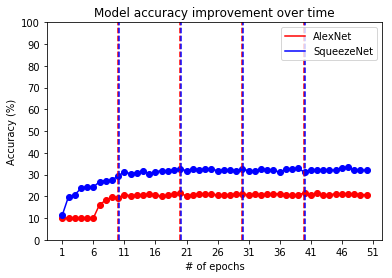

<IPython.core.display.Javascript object>


{AlexNet} Test set: Average loss: 1.9653, Accuracy: 2104/10000 (21%)


{SqueezeNet} Test set: Average loss: 1.8005, Accuracy: 3340/10000 (33%)



In [ ]:
#@title Training
from google.colab import widgets
import matplotlib.pyplot as plt
import numpy as np
import re

grid = widgets.Grid(2, 1)
catch = CatchIO()
find_lr = re.compile("[0-9.e-]*.$")

if _alex_enabled or 'alex_results' not in locals():
    alex_results = np.full((1+_nb_epochs, 3), np.nan)
    alex_results[0, 2] = locals().get('_alex_learning_rate', np.nan)

squeeze_results = np.full((1+_nb_epochs, 3), np.nan)
squeeze_results[0, 2] = _squeeze_learning_rate

# Prepare figure
plot_results_to_grid(grid, (0, 0), alex_results, "AlexNet", "r", squeeze_results, "SqueezeNet", "b")

for epoch in range(1, _nb_epochs + 1):
    # Display training output
    with grid.output_to(1, 0):
        if _alex_enabled:
            elapsed_time("AlexNet", 0)
            if "Step" == _alex_scheduler:
                alex_sch.step()
            
            alex_results[epoch-1, 2] = alex_opt.param_groups[0]['lr']
            
            train(alex, "AlexNet", "cuda", train_loader, alex_opt, epoch)
            alex_results[epoch-1, :2] = validate(alex, "AlexNet", "cuda", valid_loader)
            if "Adaptive" == _alex_scheduler:
                alex_sch.step(alex_results[epoch-1, 0])
            elapsed_time("AlexNet", 1)

        elapsed_time("SqueezeNet", 0)
        squeeze_sch.step()
        if "Step" == _squeeze_scheduler:
            squeeze_results[epoch-1, 2] = squeeze_opt.param_groups[0]['lr']
        train(squeeze, "SqueezeNet", "cuda", train_loader, squeeze_opt, epoch)
        squeeze_results[epoch-1, :2] = validate(squeeze, "SqueezeNet", "cuda", valid_loader)
        if "Adaptive" == _squeeze_scheduler:
            squeeze_sch.step(squeeze_results[epoch-1, 0])
        elapsed_time("SqueezeNet", 1)

    plot_results_to_grid(grid, (0, 0), alex_results, "AlexNet", "r", squeeze_results, "SqueezeNet", "b")

    
if _alex_enabled:
    alex_results[-1, :2] = test(alex, "AlexNet", "cuda", test_loader)
squeeze_results[-1, :2] = test(squeeze, "SqueezeNet", "cuda", test_loader)

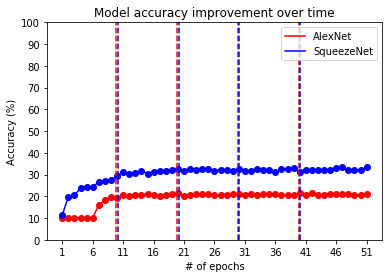

In [ ]:
#@title Results
import matplotlib.pyplot as plt

plot_results(alex_results, "AlexNet", "r", squeeze_results, "SqueezeNet", "b")

In [ ]:
#@title Download
from google.colab import files
import datetime
import tarfile
import joblib
import os

if os.path.exists('out'):
    for f in os.listdir('out'):
        os.remove(os.path.join('out', f))
else:
    os.mkdir('out')

params = \
{
    '_nb_epochs': _nb_epochs,
    '_dataset': _dataset,
    '_interpolation_method': _interpolation_method,
    '_alex_enabled': _alex_enabled,
    '_alex_learning_rate': _alex_learning_rate,
    '_alex_momentum': _alex_momentum,
    '_alex_weight_decay': _alex_weight_decay,
    '_alex_scheduler': _alex_scheduler,
    '_alex_step_size': _alex_step_size,
    '_alex_gamma': _alex_gamma,
    '_alex_pretrained': _alex_pretrained,
    '_squeeze_learning_rate': _squeeze_learning_rate,
    '_squeeze_momentum': _squeeze_momentum,
    '_squeeze_weight_decay': _squeeze_weight_decay,
    '_squeeze_scheduler': _squeeze_scheduler,
    '_squeeze_step_size': _squeeze_step_size,
    '_squeeze_gamma': _squeeze_gamma,
    '_squeeze_pretrained': _squeeze_pretrained
}

joblib.dump(params, 'out/params.joblib')
torch.save(squeeze.state_dict(), 'out/SqueezeNet.pt')
joblib.dump([alex_results, squeeze_results], 'out/results.joblib', compress=3)

if _alex_enabled:
    torch.save(alex.state_dict(), 'out/AlexNet.pt')

output_filename = "alex_vs_squeeze_{}.tar.gz".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
)
with tarfile.open(output_filename, "w:gz") as tar:
    outfiles = os.listdir('out')
    for f in outfiles:
        tar.add(os.path.join('out', f))

# output_filename = "/gdrive/My Drive/COMP551_Assignment4/alex_vs_squeeze_{}.tar.gz".format(
#     datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
# )
# with tarfile.open(output_filename, "w:gz") as tar:
#     outfiles = os.listdir('out')
#     for f in outfiles:
#         tar.add(os.path.join('out', f))

drive_savefolder = "/gdrive/My Drive/COMP551_Assignment4/" #@param {type:"string"}

output_filename = os.path.join(drive_savefolder, "alex_vs_squeeze_{}.joblib".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
))
joblib.dump([params, alex_results, squeeze_results], output_filename, compress=3)

['/gdrive/My Drive/COMP551_Assignment4/alex_vs_squeeze_2019-04-17_081656.joblib']

In [ ]:
#@title Learning parameter grid search
# from google.colab import widgets
# import matplotlib.pyplot as plt
# import numpy as np
# import datetime
# import joblib
# import re

# drive_savefolder = "/gdrive/My Drive/COMP551_Assignment4/" #@param {type:"string"}

# def train_nonan(model, model_name, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
        
#         loss.backward()
#         optimizer.step()
#         if batch_idx % _log_interval == 0:
#             print('{{{}}} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                     model_name, epoch, batch_idx * len(data),
#                     len(train_loader.dataset),
#                     100. * batch_idx / len(train_loader), loss.item()
#                 )
#             )
    
#     # Need to finish batch so that loader will reset for next model/batch
#     return not np.isnan(loss.cpu().detach().numpy())

# def test_nonan(model, model_name, device, loader, notnan):

#     if notnan:
#         test(squeeze, "SqueezeNet", "cuda", test_loader)
#     else:
#         print(
#             '\n{{{}}} Test set: Average loss: {:.4f}, Accuracy: {} ({})\n'
#             .format(
#                 model_name, np.nan, np.nan, np.nan
#             )
#         )
#         return np.nan, np.nan
  
    
# def do(_alex_learning_rate, _alex_momentum, _alex_weight_decay, _squeeze_learning_rate, _squeeze_momentum, _squeeze_weight_decay):
    
#     alex_notnan = True
#     squeeze_notnan = True
    
#     # Initialize AlexNet
#     if _alex_enabled:
#         alex = AlexNet().to("cuda")
#         alex_opt = optim.SGD(
#             alex.parameters(), lr=_alex_learning_rate, momentum=_alex_momentum, weight_decay=_alex_weight_decay)
#         if "Step" == _alex_scheduler:
#             alex_sch = optim.lr_scheduler.StepLR(alex_opt, _alex_step_size, _alex_gamma)
#         elif "Adaptive" == _alex_scheduler:
#             alex_sch = optim.lr_scheduler.ReduceLROnPlateau(alex_opt, factor=0.5, patience=2, verbose=True)
#         else:
#             assert False, "Scheduler type not recognized."

#     # Initialize SqueezeNet
#     squeeze = SqueezeNet().to("cuda")
#     squeeze_opt = optim.SGD(
#         squeeze.parameters(), lr=_squeeze_learning_rate, momentum=_squeeze_momentum, weight_decay=_squeeze_weight_decay
#     )
#     if "Step" == _squeeze_scheduler:
#         squeeze_sch = optim.lr_scheduler.StepLR(squeeze_opt, _squeeze_step_size, _squeeze_gamma)
#     elif "Adaptive" == _squeeze_scheduler:
#         squeeze_sch = optim.lr_scheduler.ReduceLROnPlateau(alex_opt, factor=0.5, patience=2, verbose=True)
#     else:
#         assert False, "Scheduler type not recognized."

#     # Done!
#     print('Dataloaders and models initialized.')
    
#     # Train and validate
#     find_lr = re.compile("[0-9.e-]*.$")

#     if _alex_enabled or 'alex_results' not in locals():
#         alex_results = np.full((1+_nb_epochs, 3), np.nan)
#         alex_results[0, 2] = locals().get('_alex_learning_rate', np.nan)

#     squeeze_results = np.full((1+_nb_epochs, 3), np.nan)
#     squeeze_results[0, 2] = _squeeze_learning_rate

#     # Prepare figure
#     plot_results_to_grid(grid, (0, 0), alex_results, "AlexNet", "r", squeeze_results, "SqueezeNet", "b")

#     for epoch in range(1, _nb_epochs + 1):
#         # Display training output
#         with grid.output_to(1, 0):
#             if _alex_enabled and alex_notnan:
#                 elapsed_time("AlexNet", 0)
#                 if "Step" == _alex_scheduler:
#                     alex_sch.step()

#                 alex_results[epoch-1, 2] = alex_opt.param_groups[0]['lr']
                
#                 alex_notnan = train_nonan(alex, "AlexNet", "cuda", train_loader, alex_opt, epoch)
#                 alex_results[epoch-1, :2] = validate(alex, "AlexNet", "cuda", valid_loader)
#                 if "Adaptive" == _alex_scheduler:
#                     alex_sch.step(alex_results[epoch-1, 0])
#                 elapsed_time("AlexNet", 1)
#             else:
#                 print("Skipping AlexNet (NaN)")
            
#             if squeeze_notnan:
#                 elapsed_time("SqueezeNet", 0)
#                 squeeze_sch.step()
#                 if "Step" == _squeeze_scheduler:
#                     squeeze_results[epoch-1, 2] = squeeze_opt.param_groups[0]['lr']
#                 squeeze_notnan = train_nonan(squeeze, "SqueezeNet", "cuda", train_loader, squeeze_opt, epoch)
#                 squeeze_results[epoch-1, :2] = validate(squeeze, "SqueezeNet", "cuda", valid_loader)
#                 if "Adaptive" == _squeeze_scheduler:
#                     squeeze_sch.step(squeeze_results[epoch-1, 0])
#                 elapsed_time("SqueezeNet", 1)
#             else:
#                 print("Skipping SqueezeNet (NaN)")

#         plot_results_to_grid(grid, (0, 0), alex_results, "AlexNet", "r", squeeze_results, "SqueezeNet", "b")

#     # Test results
#     if _alex_enabled:
#         alex_results[-1, :2] = test_nonan(alex, "AlexNet", "cuda", test_loader, alex_notnan)
    
#     squeeze_results[-1, :2] = test_nonan(squeeze, "SqueezeNet", "cuda", test_loader, squeeze_notnan)
    
#     # Save results
#     params = \
#     {
#         '_nb_epochs': _nb_epochs,
#         '_dataset': _dataset,
#         '_interpolation_method': _interpolation_method,
#         '_alex_enabled': _alex_enabled,
#         '_alex_learning_rate': _alex_learning_rate,
#         '_alex_momentum': _alex_momentum,
#         '_alex_weight_decay': _alex_weight_decay,
#         '_alex_scheduler': _alex_scheduler,
#         '_alex_step_size': _alex_step_size,
#         '_alex_gamma': _alex_gamma,
#         '_alex_pretrained': _alex_pretrained,
#         '_squeeze_learning_rate': _squeeze_learning_rate,
#         '_squeeze_momentum': _squeeze_momentum,
#         '_squeeze_weight_decay': _squeeze_weight_decay,
#         '_squeeze_scheduler': _squeeze_scheduler,
#         '_squeeze_step_size': _squeeze_step_size,
#         '_squeeze_gamma': _squeeze_gamma,
#         '_squeeze_pretrained': _squeeze_pretrained
#     }
#     output_filename = os.path.join(drive_savefolder, "alex_vs_squeeze_{}.joblib".format(
#         datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
#     ))
#     joblib.dump([params, alex_results, squeeze_results], output_filename, compress=3)
    
#     return [alex_results[-1, 0], squeeze_results[-1, 0]]

# LearningRate = [0.09, 0.05, 0.01, 0.005, 0.001]
# Momentum = [0.9, 0.5, 0.1]
# WeightDecay = [0, 0.0002]
# search = {}
# grid = widgets.Grid(2, 1)

# for lr in LearningRate:
#     for m in Momentum:
#         for wd in WeightDecay:
#             search[(lr,m,wd)] = do(lr, m, wd, lr, m, wd)

# joblib.dump(search, os.path.join(drive_savefolder, 'alex_squeeze_grid_search_{}.joblib'.format(
#     datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
# )))